# Loading libraries and data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Suppress warnings to run smoothly the code
import warnings
warnings.filterwarnings("ignore")

# Import libraries
from scipy.stats import norm
from IPython.display import display
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch.univariate import arch_model
from sklearn.utils import resample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import ipywidgets as widgets

In [2]:
# Importing file for CMC Crypto 200 Index with weekly data
cmc_prices = pd.read_excel("CMC_prices.xlsx", parse_dates = True)
cmc_prices = cmc_prices.set_index("Date")
cmc_prices.head()

,CMC Prices
Date,
2019-01-04,104.48
2019-01-11,97.45
2019-01-18,96.23
2019-01-25,94.87
2019-02-01,90.30


In [3]:
# Importing file for T-Bill 3 months with weekly data
tbill = pd.read_excel("Tbills.xlsx", parse_dates = True)
tbill = tbill.set_index("Date")

# Taking the T-Bill mean for backtesting
tbill_bt = np.float64(tbill.mean())
round(tbill_bt,4)

0.0005

In [4]:
tbill_ann = np.float64(((1+tbill).prod())**(52/tbill.shape[0])-1)
round(tbill_ann,4)

0.0257

In [5]:
# Computing returns for CMC
cmc_rets = cmc_prices.pct_change().dropna()
cmc_rets.columns = ["CMC Returns"]
cmc_rets.head()

,CMC Returns
Date,
2019-01-11,-0.067286
2019-01-18,-0.012519
2019-01-25,-0.014133
2019-02-01,-0.048171
2019-02-08,0.059358


In [6]:
# Creating a Pandas DataFrame with CMC returns
risky_r = pd.DataFrame(cmc_rets)

# Checking the shape of the DataFrame
risky_r.shape

(173, 1)

In [7]:
# Computing annualized volatility used for OBPI calculations
cmc_sigma = np.float64(risky_r.std()*(np.sqrt(52)))
round(cmc_sigma,4)

0.7138

In [8]:
# Importing file for S&P Cryptocurrency Broad Digital Market Index with weekly data
sp_prices = pd.read_excel("SP_crypto.xlsx", parse_dates = True)
sp_prices = sp_prices.set_index("Date")
sp_prices.head()

,S&P Prices
Date,
2019-01-11,329.59
2019-01-18,323.98
2019-01-25,319.29
2019-02-01,306.21
2019-02-08,325.48


In [9]:
# Computing returns for S&P Crypto Index
sp_rets = sp_prices.pct_change().dropna()
sp_rets.head()

,S&P Prices
Date,
2019-01-18,-0.017021
2019-01-25,-0.014476
2019-02-01,-0.040966
2019-02-08,0.062931
2019-02-15,-0.011552


In [10]:
# T-Bill for simulations
tbill_sim = 0.021/52
round(tbill_sim,4)

0.0004

# Functions

In [11]:
def box_pierce (r):
    """
    Computed Box-Pierce test
    """
    l_rows= ["CMC rets"]
    returns = np.array(r)
    l_cols = ("Q","p(Q)")
    qtests = np.empty((1,2))         
    for i in range(1):
        qtest_loop = sm.stats.acorr_ljungbox(returns[:,i], lags=[1], boxpierce=True)
        qtests[i,:]= qtest_loop[2:]
    qtests = pd.DataFrame(data=qtests,columns=l_cols, index=l_rows)
    return qtests


def correlogram_plot (r):
    """
    Plot the Correlogram
    """
    returns = np.array(r)
    lags=np.arange(1,11,1)
    plot_acf(returns[:,0],lags=lags)
    return plt.show()


def annualize_rets(r, periods_per_year):
    """
    Annualize a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualize the volatility of a set of returns
    """
    return r.std()*(periods_per_year**0.5)


def drawdown (return_series: pd.Series):
    """
    Take a time series of asset returns and compute/return a DataFrame that contains:
    1. Wealth index
    2. Previous peaks
    3. Percent drawdowns
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks= wealth_index.cummax()
    drawdown = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks": previous_peaks,
        "Drawdown": drawdown
    })


def skewness(r):
    """
    Compute the skewness of the supplied Series/DataFrame
    Alternative to scipy.stats.skew()
    Return a float/Series
    """
    demeaned_r = r - r.mean()
    # Use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Compute the kurtosis of the supplied Series/DataFrame
    Alternative to scipy.stats.kurtosis()
    Return a float/Series
    """
    demeaned_r = r - r.mean()
    # Use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4


def var_historic (r, level=5):
    """
    Compute Value-at-Risk Historic
    """
    if isinstance(r,pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance (r,pd.Series):
        return -np.percentile(r,level)
    else: 
        raise TypeError("Expected r to be Series or DataFrame")


def var_gaussian(r, level=5, modified=False):
    """
    Return the Parametric Gaussian Value-at-Risk of a Series/DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # Compute the Z-score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # Modify the Z-score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))


def cvar_historic(r, level=5):
    """
    Compute the Conditional Value-at-Risk of Series/DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")
        

def semideviation(r,periods_per_year=52):
    """
    Compute the Annualized Semi-Deviation
    """
    neg_rets = r[r<0]
    return annualize_vol(r = neg_rets, periods_per_year=periods_per_year)        
   

def rovar(r,periods_per_year,level=5):
    """
    Compute the Return on Value-at-Risk
    """
    return annualize_rets(r,periods_per_year=periods_per_year)/abs(var_historic(r,level=level))


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Compute the annualized Sharpe Ratio of a set of returns
    """
    # Convert the annual risk-free rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol


def sortino_ratio(r, riskfree_rate, periods_per_year):
    """
    Compute the annualized Sortino Ratio of a set of returns
    """
    # Convert the annual risk-free rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    neg_rets = excess_ret[excess_ret<0]
    ann_vol = annualize_vol(neg_rets, periods_per_year)
    return ann_ex_ret/ann_vol


def calmar_ratio(r, riskfree_rate, periods_per_year):
    """
    Compute the annualized Calmar Ratio of a set of returns
    """
    # Convert the annual risk-free rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    max_dd = abs(drawdown(r).Drawdown.min())
    return ann_ex_ret/max_dd


def burke_ratio(r, riskfree_rate, periods_per_year, modified = False):
    """
    Compute the annualized Burke Ratio of a set of returns
    If "modified" is True, then the modified Burke Ratio is returned
    """
    # Convert the annual risk-free rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    sum_dwn = np.sqrt(np.sum((drawdown(r).Drawdown)**2))
    if modified == False:
        bk_ratio = ann_ex_ret/sum_dwn
    else:
        bk_ratio = ann_ex_ret/sum_dwn * np.sqrt(len(r))
    return bk_ratio


def summary_stats(r, riskfree_rate=np.float64(tbill_bt), periods_per_year=52):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=periods_per_year)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=periods_per_year)
    semidev = r.aggregate(semideviation, periods_per_year=periods_per_year)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    ann_cr = r.aggregate(calmar_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    ann_br = r.aggregate(burke_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year, modified = True)
    ann_sortr = r.aggregate(sortino_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    hist_var5 = r.aggregate(var_historic)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    rovar5 = r.aggregate(rovar, periods_per_year=periods_per_year)
    return pd.DataFrame({
        "Annualized Return": round(ann_r,4),
        "Annualized Volatility": round(ann_vol,4),
        "Semi-Deviation": round(semidev,4),
        "Skewness": round(skew,4),
        "Kurtosis": round(kurt,4),
        "Historic VaR (5%)": round(hist_var5,4),
        "Cornish-Fisher VaR (5%)": round(cf_var5,4),
        "Historic CVaR (5%)": round(hist_cvar5,4),
        "Return on VaR": round(rovar5,4),
        "Sharpe Ratio": round(ann_sr,4),
        "Sortino Ratio": round(ann_sortr,4),
        "Calmar Ratio": round(ann_cr,4),
        "Modified Burke Ratio": round(ann_br,4),
        "Max Drawdown": round(dd,4)
    })



def run_hold (risky_r, safe_r = None, start = 100000, risky_w=0.6, riskfree_rate = tbill_bt, periods_per_year = 52):
    """
    Compute the Buy-and-Hold portfolio where weights for risky/safe assets can vary according to the parameters selected in the function
    """
    # Set up the buy-and-hold 60/40 portfolio parameters
    dates = risky_r.index
    n_steps = len(dates)
    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/periods_per_year
    safe_w = 1 - risky_w
    # Allocations to risky/safe assets according to the parameters selected in the function
    risky_alloc = (start * risky_w) * (1+risky_r).cumprod()
    safe_alloc = (start * safe_w) * (1+safe_r).cumprod()
    
    port_history = pd.DataFrame().reindex_like(risky_r)
    port_history = risky_alloc + safe_alloc
    
    vocabulary_result = {
        "Buy-and-Hold": port_history, 
        "Risky Allocation": risky_alloc,
        "Safe Allocation": safe_alloc,
        "Risky Weight": risky_w
    }
    return vocabulary_result


def run_obpi(prices, start = 100000, K = 250, r = tbill_ann, sigma = cmc_sigma, periods_per_year = 52, jump_pct = None):
    """
    Compute the Option Based Portfolio Insurance with constant volatility
    """
    def priceVanillaOption(S,K,T,r,sigma):
        """
        Calculate plain-vanilla European Put options with analytical formula
        """
        d1 = (np.log(S/K) + (r + (sigma**2)/2)*T) /(sigma*np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        value = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        return value
    def delta_hedging(S,K,T,r,sigma):
        """
        Compute the Delta Hedging for European Put options
        """
        d1 = (np.log(S/K) + (r + (sigma**2)/2)*T) /(sigma*np.sqrt(T))
        delta = norm.cdf(d1) - 1
        return delta
    # Set up the OBPI parameters
    prices = pd.DataFrame(prices)
    risky_r = pd.DataFrame(prices.pct_change().dropna())
    expiry = prices.shape[0]
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    
    # Creating DataFrames to store values
    delta_history = pd.DataFrame().reindex_like(risky_r)
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    floorval_history = pd.DataFrame().reindex_like(risky_r)
    put_history = pd.DataFrame().reindex_like(risky_r)
    t_to_mat = pd.DataFrame().reindex_like(risky_r)
    safe_r = pd.DataFrame().reindex_like(risky_r)
    safe_r.values[:] = r/periods_per_year
    
    for step in range(n_steps):
        strike_v = (K / 100) * start 
        S = prices.iloc[step]
        expiry = expiry - 1
        T = expiry / periods_per_year
        price_put = priceVanillaOption(S, K, T, r, sigma)
        delta_put = delta_hedging(S,K,T,r,sigma)
        if jump_pct is not None:
            # In case there is a return jump higher than the selected jump_pct parameter, the delta get divided by 4
            risky_r.iloc[-1] = 0
            diff_price = risky_r.iloc[step]-risky_r.iloc[step-1]
            jump = diff_price[(np.absolute(diff_price)>=jump_pct)]
            if jump.any() == True:
                delta_put = delta_put*4
        risky_asset = (1 + delta_put) * S
        risky_w = risky_asset / (price_put + S)
        risky_w = np.minimum(risky_w, 0.85)
        risky_w = np.maximum(risky_w, 0.15)  
        safe_w = 1 - risky_w     
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # Recompute the new account value at the end of this step
        account_value = risky_alloc * (1+ risky_r.iloc[step]) + safe_alloc * (1 + safe_r.iloc[step])
        # Save the histories for analysis and plotting
        delta_history.iloc[step] = delta_put
        account_history.iloc[step] = account_value
        t_to_mat.iloc[step] = T
        risky_w_history.iloc[step] = risky_w
        floorval_history.values[:] = strike_v
        put_history.iloc[step] = price_put
        
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risky Allocation": risky_w_history,
        "Start": start,
        "Strike Price": K,
        "Delta History": delta_history,
        "Time to Maturity": t_to_mat,
        "Floor History": floorval_history,
        "Put Price History": put_history,
        "Jump Percentage": jump_pct
    }
    return backtest_result


def run_cppi(risky_r, safe_r=None, m=6, start=100000, floor=0.9, riskfree_rate=tbill_bt, periods_per_year = 52, drawdown=None, jump_pct=None):
    """
    Compute the Constant Proportion Portfolio Insurance
    """
    # Set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor
    peak = account_value
    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])
    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/periods_per_year
    
    # Creating DataFrames to store values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    floorval_history = pd.DataFrame().reindex_like(risky_r)
    peak_history = pd.DataFrame().reindex_like(risky_r)
    mult_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        mult = m
        if jump_pct is not None:
            # In case there is a return jump higher than the selected jump_pct parameter, the multiple get divided by 4
            risky_r.iloc[-1] = 0
            diff_price = risky_r.iloc[step]-risky_r.iloc[step-1]
            jump = diff_price[(np.absolute(diff_price)>=jump_pct)]
            if jump.any() == True:
                mult = m/4
        if drawdown is not None:
            # In case the parameter for drawdown is not none, the floor value becomes dynamic
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)
        cushion = (account_value - floor_value)/account_value
        risky_w = mult*cushion
        risky_w = np.minimum(risky_w, 0.9)
        risky_w = np.maximum(risky_w, 0.1)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # Recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # Save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
        floorval_history.iloc[step] = floor_value
        peak_history.iloc[step] = peak
        mult_history.iloc[step] = mult

    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "Multiple History": mult_history,
        "Multiple": m,
        "Start": start,
        "Floor": floor,
        "Drawdown": drawdown,
        "Peak": peak_history,
        "Floor History": floorval_history,
        "Jump Percentage": jump_pct
    }
    return backtest_result


def gbm(n_years = 1, n_scenarios_gbm=10000, mu_gbm=0.7, sigma_gbm=0.3, periods_per_year_gbm=52, s_0 = 100000, prices = True):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices through Monte Carlo
    :param n_years:  n° of years to generate data for
    :param n_paths: n° of scenarios/trajectories
    :param mu: annualized drift (market return)
    :param sigma: annualized volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/periods_per_year_gbm
    n_steps = int(n_years*periods_per_year_gbm) + 1
    rets_plus_1 = np.random.normal(loc=(1+mu_gbm)**dt, scale=(sigma_gbm*np.sqrt(dt)), size=(n_steps, n_scenarios_gbm))
    rets_plus_1[0] = 1
    ret_val = s_0*pd.DataFrame(rets_plus_1).cumprod() if prices else rets_plus_1-1
    return ret_val

# Backtesting

## 60/40 Portfolio

In [12]:
# Run the 60/40 Portfolio backtesting
sixty_forty = run_hold(risky_r)

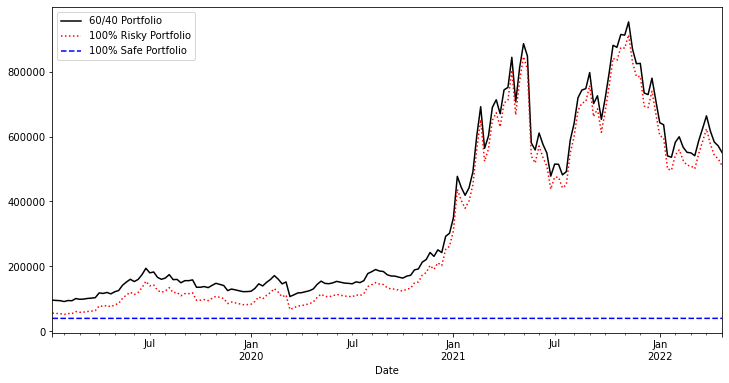

In [188]:
# Plot 60/40 Portfolio, 100% Risky Portfolio, and 100% safe Portfolio
ax = sixty_forty["Buy-and-Hold"].plot(figsize=(12,6), color = "k")
sixty_forty["Risky Allocation"].plot(ax=ax,figsize=(12,6),color = "r",linestyle=":")
sixty_forty["Safe Allocation"].plot(ax=ax, figsize=(12,6),color="b", linestyle="--")
plt.legend(["60/40 Portfolio","100% Risky Portfolio","100% Safe Portfolio"]);

In [14]:
# Get the terminal value for 60/40 Portfolio
term_wealth_bh = np.float64(sixty_forty["Buy-and-Hold"].iloc[-1])
round(term_wealth_bh,2)

550662.3

In [15]:
# Compute returns for 60/40 Portfolio
hold_rets = sixty_forty["Buy-and-Hold"].pct_change().dropna()
hold_rets.columns = ["60/40 Portfolio Returns"]
hold_rets.head()

,60/40 Portfolio Returns
Date,
2019-01-18,-0.007297
2019-01-25,-0.008195
2019-02-01,-0.027773
2019-02-08,0.033513
2019-02-15,-0.005864


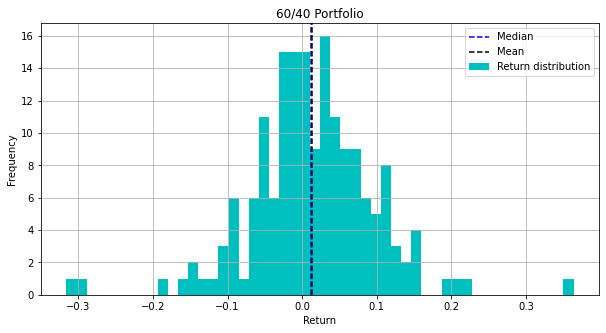

In [16]:
# Plot return distribution with median and mean for 60/40 Portfolio
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
plt.axvline(np.float64(hold_rets.median()), color = "b", ls = "--")
plt.axvline(np.float64(hold_rets.mean()), color = "k", ls = "--")
hold_rets.hist(bins=50, ax=ax1, color = "c")
ax1.set_xlabel('Return')
ax1.set_ylabel('Frequency')
ax1.set_title('60/40 Portfolio')
plt.legend(["Median", "Mean", "Return distribution"]);

In [17]:
box_pierce(hold_rets)

,Q,p(Q)
CMC rets,0.722472,0.395334


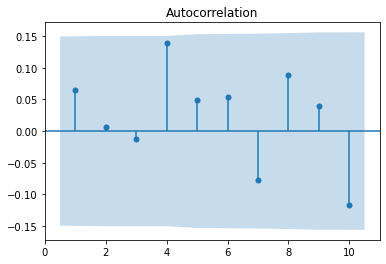

In [18]:
correlogram_plot(hold_rets)

In [19]:
hold_mu= np.float64(summary_stats(hold_rets)["Annualized Return"])
round(hold_mu,4)

0.6959

In [20]:
hold_w = np.float64(sixty_forty["Risky Weight"])
hold_w

0.6

## OBPI

In [21]:
# Run the OBPI backtesting
cmc_obpi = run_obpi(cmc_prices)

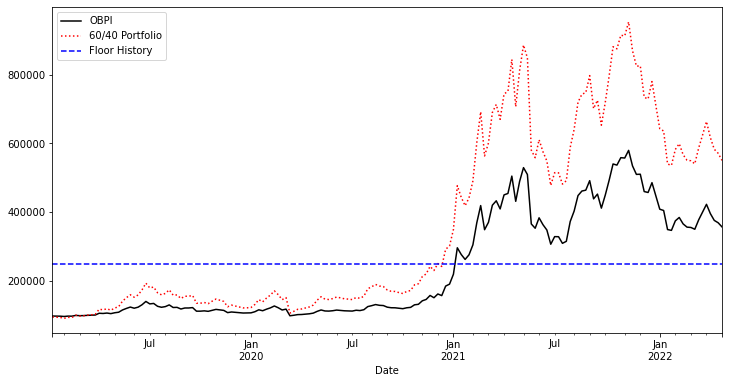

In [22]:
# Plot OBPI Portfolio and 60/40 Portfolio with floor history
ax = cmc_obpi["Wealth"].plot(figsize=(12,6), color = "k")
sixty_forty["Buy-and-Hold"].plot(ax=ax,figsize=(12,6),color = "r", style=":")
cmc_obpi["Floor History"].plot(ax=ax,figsize=(12,6), color = "b", style="--")
plt.legend(["OBPI", "60/40 Portfolio", "Floor History"]);

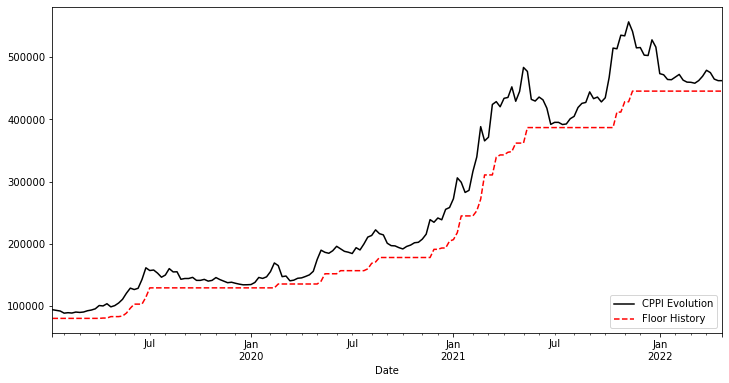

In [206]:
# Plot OBPI Portfolio and 60/40 Portfolio with floor history
ax = cmc_cppi_ev["Wealth"].plot(figsize=(12,6), color = "k")
cmc_cppi_ev["Floor History"].plot(ax=ax,figsize=(12,6), color = "r", style="--")
plt.legend(["CPPI Evolution", "Floor History"], loc = "lower right");

In [23]:
# Get the terminal value for OBPI
term_wealth_obpi = np.float64(cmc_obpi["Wealth"].iloc[-1])
round(term_wealth_obpi,2)

357368.65

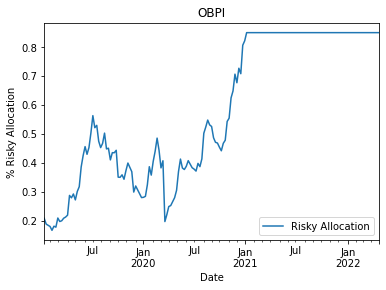

In [24]:
# Plot the risky allocation for OBPI
cmc_obpi["Risky Allocation"].plot()
plt.ylabel("% Risky Allocation")
plt.title("OBPI")
plt.legend(["Risky Allocation"], loc="lower right");

In [25]:
# Compute returns for OBPI
obpi_rets = cmc_obpi["Wealth"].pct_change().dropna()
obpi_rets.columns = ["OBPI Returns"]
obpi_rets.head()

,OBPI Returns
Date,
2019-01-18,-0.001960
2019-01-25,-0.002206
2019-02-01,-0.008278
2019-02-08,0.010324
2019-02-15,-0.001433


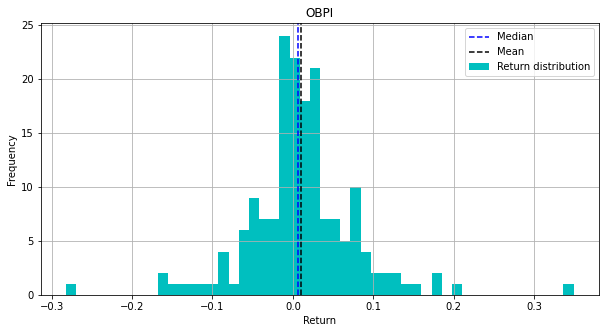

In [26]:
# Plot return distribution with median and mean for OBPI
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
plt.axvline(np.float64(obpi_rets.median()), color = "b", ls = "--")
plt.axvline(np.float64(obpi_rets.mean()), color = "k", ls = "--")
obpi_rets.hist(bins=50, ax=ax1, color = "c")
ax1.set_xlabel('Return')
ax1.set_ylabel('Frequency')
ax1.set_title('OBPI')
plt.legend(["Median", "Mean", "Return distribution"]);

In [27]:
box_pierce(obpi_rets)

,Q,p(Q)
CMC rets,1.433926,0.231125


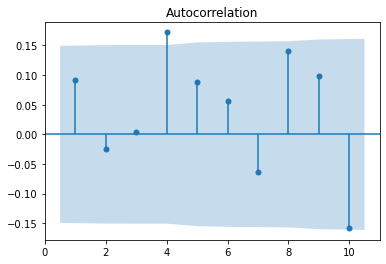

In [28]:
correlogram_plot(obpi_rets)

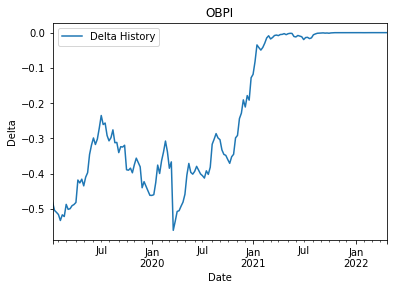

In [29]:
cmc_obpi["Delta History"].plot()
plt.ylabel("Delta")
plt.title("OBPI")
plt.legend(["Delta History"], loc="upper left");

In [30]:
obpi_mu= np.float64(summary_stats(obpi_rets)["Annualized Return"])
round(obpi_mu,4)

0.4758

In [31]:
obpi_k = np.float64(cmc_obpi["Strike Price"])
obpi_k

250.0

## Evolution of PI Strategies: OBPI subject to price jumps

In [32]:
# Run the OBPI backtesting
cmc_obpi_ev = run_obpi(cmc_prices, jump_pct = 0.1)

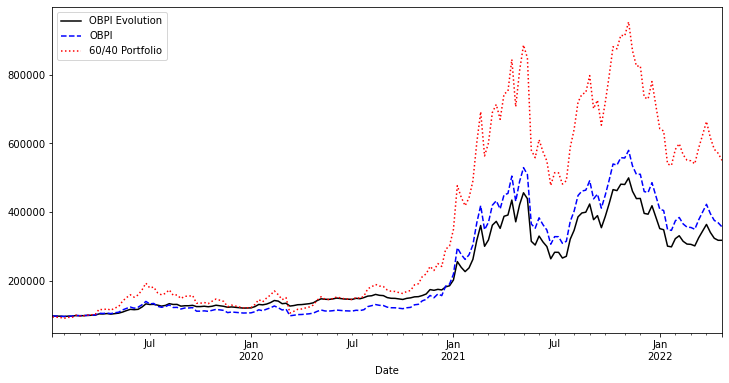

In [33]:
# Plot OBPI subject to price jumps, OBPI Portfolio and 60/40 Portfolio with floor history
ax = cmc_obpi_ev["Wealth"].plot(figsize=(12,6), color = "k")
cmc_obpi["Wealth"].plot(ax=ax, figsize=(12,6), color = "b", style = "--")
sixty_forty["Buy-and-Hold"].plot(ax=ax,figsize=(12,6),color = "r", style=":")
plt.legend(["OBPI Evolution","OBPI", "60/40 Portfolio"]);

In [34]:
# Get the terminal value for OBPI
term_wealth_obpi_ev = np.float64(cmc_obpi_ev["Wealth"].iloc[-1])
round(term_wealth_obpi_ev,2)

318627.93

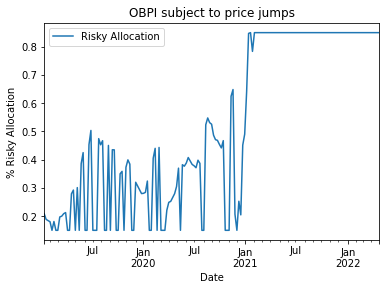

In [35]:
# Plot the risky allocation for OBPI
cmc_obpi_ev["Risky Allocation"].plot()
plt.ylabel("% Risky Allocation")
plt.title("OBPI subject to price jumps")
plt.legend(["Risky Allocation"], loc="upper left");

In [36]:
# Compute returns for OBPI
obpi_rets_ev = cmc_obpi_ev["Wealth"].pct_change().dropna()
obpi_rets_ev.columns = ["OBPI Returns"]
obpi_rets_ev.head()

,OBPI Returns
Date,
2019-01-18,-0.001960
2019-01-25,-0.002206
2019-02-01,-0.008278
2019-02-08,0.009324
2019-02-15,-0.001433


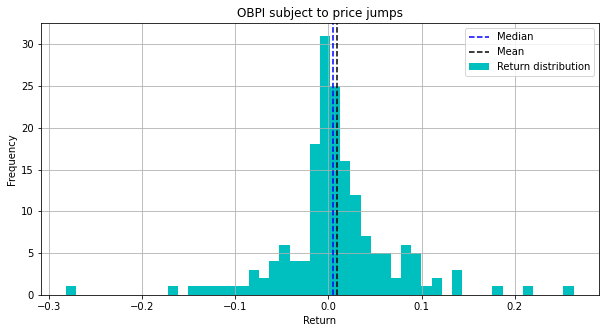

In [37]:
# Plot return distribution with median and mean for OBPI
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
plt.axvline(np.float64(obpi_rets_ev.median()), color = "b", ls = "--")
plt.axvline(np.float64(obpi_rets_ev.mean()), color = "k", ls = "--")
obpi_rets_ev.hist(bins=50, ax=ax1, color = "c")
ax1.set_xlabel('Return')
ax1.set_ylabel('Frequency')
ax1.set_title('OBPI subject to price jumps')
plt.legend(["Median", "Mean", "Return distribution"]);

In [38]:
box_pierce(obpi_rets_ev)

,Q,p(Q)
CMC rets,1.665055,0.196922


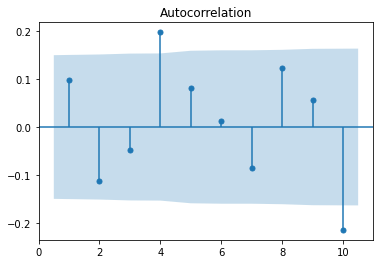

In [39]:
correlogram_plot(obpi_rets_ev)

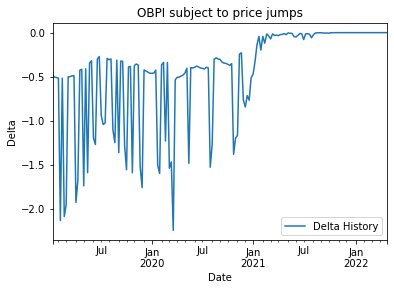

In [40]:
cmc_obpi_ev["Delta History"].plot()
plt.ylabel("Delta")
plt.title("OBPI subject to price jumps")
plt.legend(["Delta History"], loc="lower right");

In [41]:
obpi_mu_ev= np.float64(summary_stats(obpi_rets_ev)["Annualized Return"])
round(obpi_mu_ev,4)

0.4255

In [42]:
obpi_k_ev = np.float64(cmc_obpi_ev["Strike Price"])
obpi_k_ev

250.0

In [43]:
obpi_jp_ev = np.float64(cmc_obpi_ev["Jump Percentage"])
obpi_jp_ev

0.1

## CPPI

In [44]:
# Run the CPPI backtesting
cmc_cppi = run_cppi(risky_r,drawdown = 0.20)

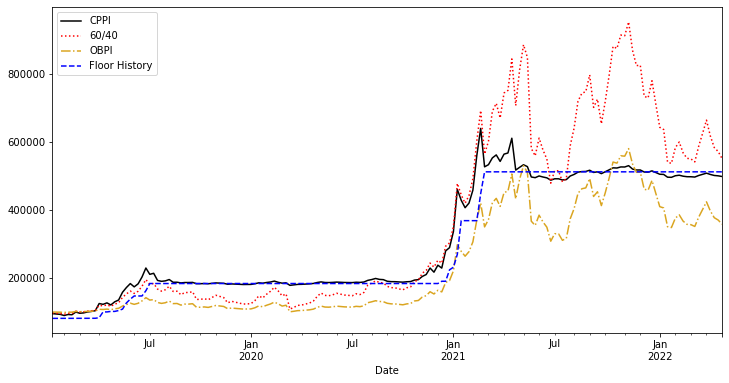

In [45]:
# Plot CPPI, 60/40 Portfolio and OBPI with floor history
ax = cmc_cppi["Wealth"].plot(figsize=(12,6), color = "k")
sixty_forty["Buy-and-Hold"].plot(ax=ax, figsize=(12,6), color="r", linestyle=":")
cmc_obpi["Wealth"].plot(ax=ax, figsize=(12,6), color="goldenrod", linestyle="-.")
cmc_cppi["Floor History"].plot(ax=ax, figsize=(12,6), color="b", linestyle="--")
plt.legend(["CPPI","60/40","OBPI","Floor History"]);

In [46]:
# Get the terminal value for CPPI
term_wealth_cppi = np.float64(cmc_cppi["Wealth"].iloc[-1])
round(term_wealth_cppi,2)

497733.43

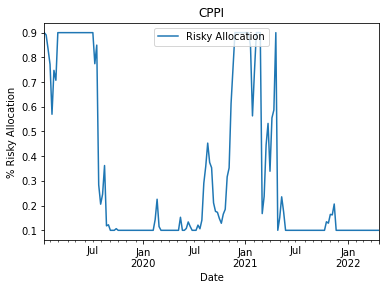

In [47]:
# Plot the risky allocation for CPPI
cmc_cppi["Risky Allocation"].plot()
plt.ylabel("% Risky Allocation")
plt.title("CPPI")
plt.legend(["Risky Allocation"], loc= "upper center");

In [48]:
# Compute returns for CPPI
cppi_rets = cmc_cppi["Wealth"].pct_change().dropna()
cppi_rets.columns = ["CPPI Returns"]
cppi_rets.head()

,CPPI Returns
Date,
2019-01-18,-0.011149
2019-01-25,-0.011771
2019-02-01,-0.037159
2019-02-08,0.033818
2019-02-15,-0.007575


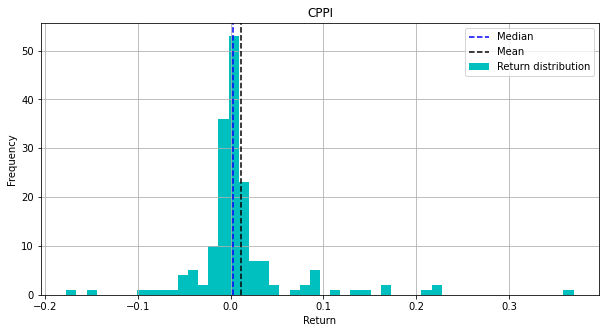

In [49]:
# Plot return distribution with median and mean for CPPI
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
plt.axvline(np.float64(cppi_rets.median()), color = "b", ls = "--")
plt.axvline(np.float64(cppi_rets.mean()), color = "k", ls = "--")
cppi_rets.hist(bins=50, ax=ax1, color = "c")
ax1.set_xlabel('Return')
ax1.set_ylabel('Frequency')
ax1.set_title('CPPI')
plt.legend(["Median", "Mean", "Return distribution"]);

In [50]:
box_pierce(cppi_rets)

,Q,p(Q)
CMC rets,1.37071,0.24169


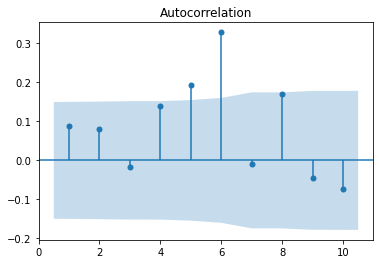

In [51]:
correlogram_plot(cppi_rets)

In [52]:
cppi_mu= np.float64(summary_stats(cppi_rets)["Annualized Return"])
round(cppi_mu,4)

0.6555

In [53]:
cppi_floor = np.float64(cmc_cppi["Floor"])
cppi_floor

0.9

In [54]:
cppi_m = cmc_cppi["Multiple"]
cppi_m

6

In [55]:
cppi_dd = np.float64(cmc_cppi["Drawdown"])
cppi_dd

0.2

## Evolution of PI Strategies: CPPI subject to price jumps

In [56]:
# Run the CPPI backtesting subject to price jumps
cmc_cppi_ev = run_cppi(risky_r, drawdown=0.2, jump_pct=0.1)

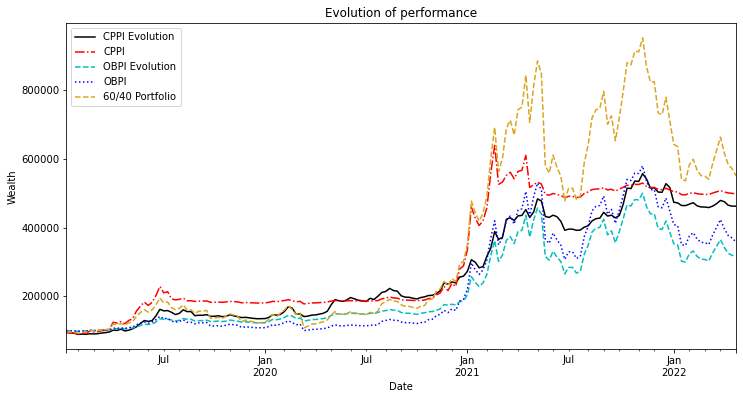

In [57]:
# Plot CPPI subject to price jumps, 60/40 Portfolio, OBPI and CPPI
ax = cmc_cppi_ev["Wealth"].plot(figsize=(12,6), color = "k")
cmc_cppi["Wealth"].plot(ax=ax, figsize=(12,6), color="r", linestyle="-.")
cmc_obpi_ev["Wealth"].plot(ax=ax, figsize=(12,6), color="c", linestyle="--")
cmc_obpi["Wealth"].plot(ax=ax, figsize=(12,6), color="b", linestyle=":")
sixty_forty["Buy-and-Hold"].plot(ax=ax, figsize=(12,6), color="goldenrod", linestyle="--")
plt.ylabel("Wealth")
plt.title("Evolution of performance")
plt.legend(["CPPI Evolution","CPPI","OBPI Evolution", "OBPI", "60/40 Portfolio"]);

In [58]:
# Get the terminal value for CPPI subject to price jumps
term_wealth_cppi_ev = np.float64(cmc_cppi_ev["Wealth"].iloc[-1])
round(term_wealth_cppi_ev,2)

462317.44

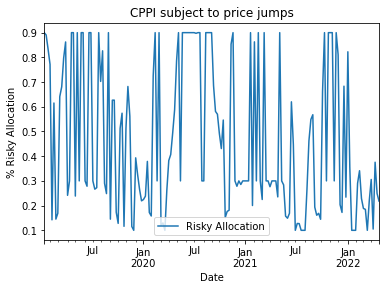

In [59]:
# Plot the risky allocation for CPPI subject to price jumps
cmc_cppi_ev["Risky Allocation"].plot()
plt.ylabel("% Risky Allocation")
plt.title("CPPI subject to price jumps")
plt.legend(["Risky Allocation"], loc= "lower center");

In [60]:
# Compute returns for CPPI subject to price jumps
cppi_rets_ev = cmc_cppi_ev["Wealth"].pct_change().dropna()
cppi_rets_ev.columns = ["CPPI EV Returns"]
cppi_rets_ev.head()

,CPPI EV Returns
Date,
2019-01-18,-0.011149
2019-01-25,-0.011771
2019-02-01,-0.037159
2019-02-08,0.008461
2019-02-15,-0.006235


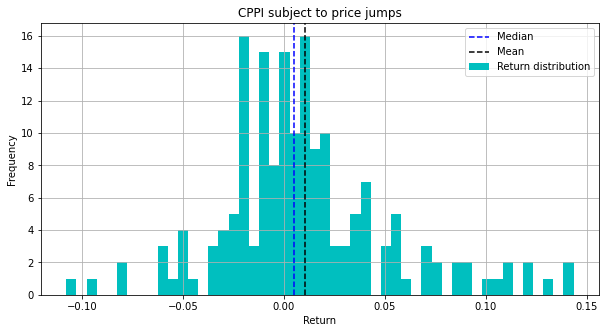

In [61]:
# Plot return distribution with median and mean for CPPI subject to price jumps
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
plt.axvline(np.float64(cppi_rets_ev.median()), color = "b", ls = "--")
plt.axvline(np.float64(cppi_rets_ev.mean()), color = "k", ls = "--")
cppi_rets_ev.hist(bins=50, ax=ax1, color = "c")
ax1.set_xlabel('Return')
ax1.set_ylabel('Frequency')
ax1.set_title('CPPI subject to price jumps')
plt.legend(["Median", "Mean", "Return distribution"]);

In [62]:
box_pierce(cppi_rets_ev)

,Q,p(Q)
CMC rets,6.639979,0.009972


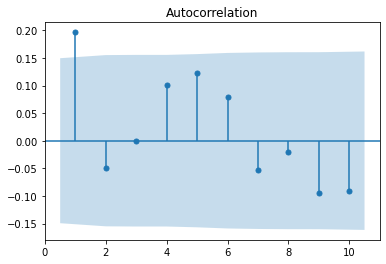

In [63]:
correlogram_plot(cppi_rets_ev)

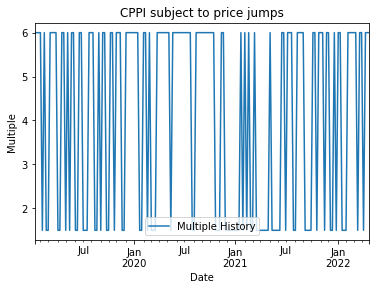

In [64]:
cmc_cppi_ev["Multiple History"].plot()
plt.ylabel("Multiple")
plt.title("CPPI subject to price jumps")
plt.legend(["Multiple History"], loc= "lower center");

In [65]:
cppi_mu_ev= np.float64(summary_stats(cppi_rets_ev)["Annualized Return"])
round(cppi_mu_ev,4)

0.6189

In [66]:
cppi_floor_ev = np.float64(cmc_cppi_ev["Floor"])
cppi_floor_ev

0.9

In [67]:
cppi_m_ev = cmc_cppi_ev["Multiple"]
cppi_m_ev

6

In [68]:
cppi_dd_ev = np.float64(cmc_cppi_ev["Drawdown"])
cppi_dd_ev

0.2

In [69]:
cppi_jp_ev = np.float64(cmc_cppi_ev["Jump Percentage"])
cppi_jp_ev

0.1

# Summary statistics for backtesting

In [70]:
summary_stats(sixty_forty["Risky Allocation"].pct_change().dropna())

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
CMC Returns,0.9511,0.7144,0.4956,-0.2165,5.8878,0.1228,0.1448,0.2078,7.7457,1.3301,1.9188,1.6851,3.5856,-0.5639


In [71]:
summary_stats(hold_rets)

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
60/40 Portfolio Returns,0.6959,0.6021,0.4261,-0.1354,6.1142,0.1102,0.1212,0.1791,6.3139,1.1545,1.6331,1.51,3.0121,-0.4603


In [72]:
summary_stats(obpi_rets)

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
OBPI Returns,0.4758,0.4936,0.35,0.3485,7.9874,0.0874,0.0887,0.1453,5.4456,0.9624,1.3572,1.1313,2.4987,-0.4199


In [73]:
summary_stats(obpi_rets_ev)

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
OBPI Returns,0.4255,0.439,0.3404,-0.0586,7.9198,0.0825,0.0861,0.1367,5.1587,0.9675,1.2481,1.0115,2.715,-0.4199


In [74]:
summary_stats(cppi_rets)

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
CPPI Returns,0.6555,0.4079,0.2283,2.3342,15.1298,0.0498,0.0246,0.0885,13.1534,1.605,2.8792,2.7453,3.8617,-0.2385


In [75]:
summary_stats(cppi_rets_ev)

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
CPPI EV Returns,0.6189,0.3065,0.1622,0.6876,4.3513,0.0515,0.0497,0.0726,12.0125,2.017,3.8069,3.2564,6.3611,-0.1898


# GARCH

## 60/40 Portfolio

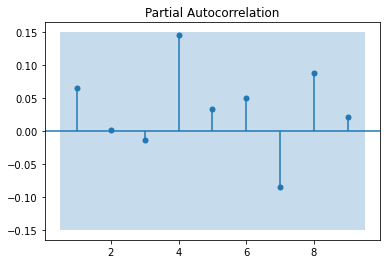

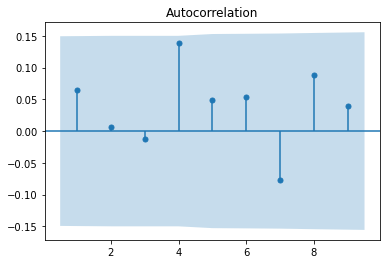

In [76]:
## Step 1: ARMA Model for the Mean with Return Diagnostic (PACF->p; ACF->q)
lags=np.arange(1,10,1)
plot_pacf(hold_rets,lags=lags)
plot_acf(hold_rets,lags=lags)
plt.show()

In [77]:
# p-value Q-test
garch_qtest=sm.stats.acorr_ljungbox(hold_rets, lags=[10], boxpierce=True)
p_val_qtest = garch_qtest[3]
print("p-value Q-test =",p_val_qtest)

p-value Q-test = [0.44013788]


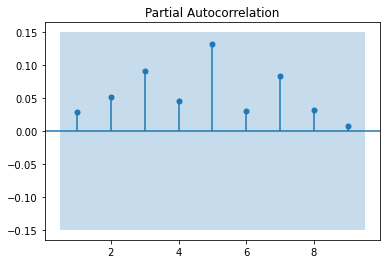

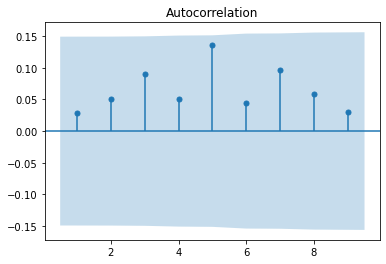

In [78]:
at = hold_rets - np.mean(hold_rets)
## Step 2: GARCH Model for the Variance
# Step 2.a: PACF Squared Residuals
plot_pacf(at**2,lags=lags)
plot_acf(at**2,lags=lags)
plt.show()

In [79]:
# Step 2.b: Model Selection with Information Criteria: AIC + BIC
out_garch_aic=np.zeros((2,2))
out_garch_bic=np.zeros((2,2))
for order_s in range(1,3,1):
    for order_q in range(1,3,1):
        print(order_q)
        garch = arch_model(at, mean='Zero', vol='GARCH', p=order_s, o=0, q=order_q, rescale=False)
        garch_result = garch.fit()
        out_garch_aic[order_s-1,order_q-1] = garch_result.aic/len(hold_rets)
        out_garch_bic[order_s-1,order_q-1] = garch_result.bic/len(hold_rets)
garch=arch_model(at,p=1,q=1,o=0, mean='Zero', vol='GARCH')
garch_result = garch.fit()

1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 26892.502789440823
Iteration:      2,   Func. Count:     11,   Neg. LLF: -176.40762175745084
Iteration:      3,   Func. Count:     18,   Neg. LLF: -184.64567135695603
Iteration:      4,   Func. Count:     23,   Neg. LLF: -189.33993573938818
Iteration:      5,   Func. Count:     28,   Neg. LLF: -186.65438561502845
Iteration:      6,   Func. Count:     33,   Neg. LLF: -192.14805997010325
Iteration:      7,   Func. Count:     37,   Neg. LLF: -192.15843939742228
Iteration:      8,   Func. Count:     41,   Neg. LLF: -192.15862952543543
Iteration:      9,   Func. Count:     45,   Neg. LLF: -192.15863119054933
Iteration:     10,   Func. Count:     48,   Neg. LLF: -192.15863119052645
Optimization terminated successfully    (Exit mode 0)
            Current function value: -192.15863119054933
            Iterations: 10
            Function evaluations: 48
            Gradient evaluations: 10
2
Iteration:      1,   Func. Count:      6,   Ne

In [80]:
## Step 3: GARCH summary
garch_summary = garch_result.summary()
garch_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Zero Mean - GARCH Model Results                          
===================================================================================
Dep. Variable:     60/40 Portfolio Returns   R-squared:                       0.000
Mean Model:                      Zero Mean   Adj. R-squared:                  0.006
Vol Model:                           GARCH   Log-Likelihood:                192.159
Distribution:                       Normal   AIC:                          -378.317
Method:                 Maximum Likelihood   BIC:                          -368.875
                                             No. Observations:                  172
Date:                     Fri, May 20 2022   Df Residuals:                      172
Time:                             21:39:29   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.7473e-04  2.926e-04      1.623      0.105 [-9.868e-05,1.048e-03]
alpha[1]       0.1164  9.914e-02      1.175      0.240   [-7.787e-02,  0.311]
beta[1]        0.8235  9.566e-02      8.609  7.350e-18      [  0.636,  1.011]
=============================================================================

Covariance estimator: robust
"""

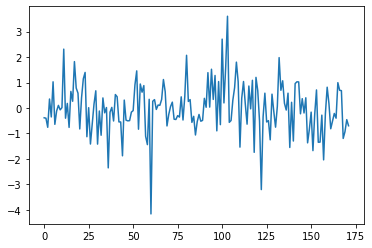

In [81]:
# Step 3.a: GARCH std residuals
garch_std_resid=garch_result._resid/garch_result._volatility
plt.plot(garch_std_resid)
plt.show()

In [82]:
# Step 3.b: Normality Test of Standardized Residuals with Jarque-Bera
jb_stat = stats.jarque_bera(garch_std_resid)
kurt_stat = stats.kurtosis(garch_std_resid)
print("JB Statistics =", jb_stat)
print("Kurtosis Statistics =",kurt_stat)

JB Statistics = Jarque_beraResult(statistic=40.00836289471462, pvalue=2.0525530164405836e-09)
Kurtosis Statistics = 2.333160806185134


In [83]:
# Step 3.c: Normality Test of Standardized Residuals with Ljung-Box
garch_qtest_resid=sm.stats.acorr_ljungbox(garch_std_resid, lags=[10], boxpierce=True)
p_val_qtest_res = garch_qtest_resid[3]
garch_qtest_squared_resid=sm.stats.acorr_ljungbox(garch_std_resid**2, lags=[10], boxpierce=True)
p_val_qtest_sqres= garch_qtest_squared_resid[3]
print("p-value Q-test Residuals =", p_val_qtest_res)
print("p-value Q-test Squared Residuals =", p_val_qtest_sqres)

p-value Q-test Residuals = [0.71304822]
p-value Q-test Squared Residuals = [0.99303306]


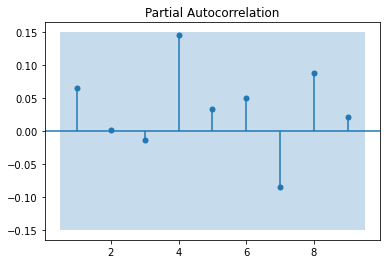

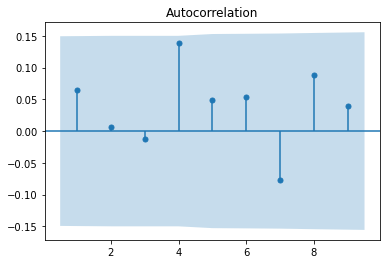

In [84]:
yh=garch_result._resid
plot_pacf(yh,lags=lags)
plot_acf(yh,lags=lags)
plt.show()

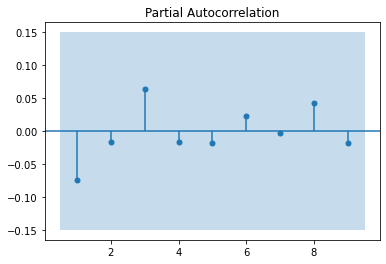

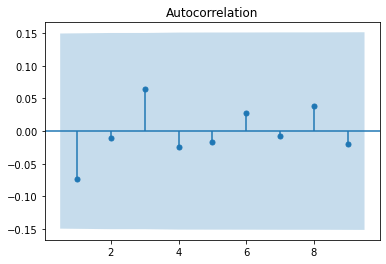

In [85]:
plot_pacf(garch_std_resid**2,lags=lags)
plot_acf(garch_std_resid**2,lags=lags)
plt.show()

In [86]:
# Simulate GARCH Volatility for the future
garch_sim = garch_result.forecast(horizon=52, reindex = False)
std_garch = (np.sqrt(garch_sim.variance.values[-1,:]))*np.sqrt(52)
hold_vol = np.float64(std_garch[-1])
round(hold_vol,4)

0.6363

## OBPI

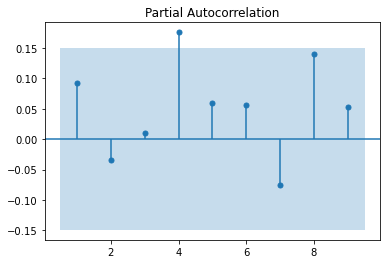

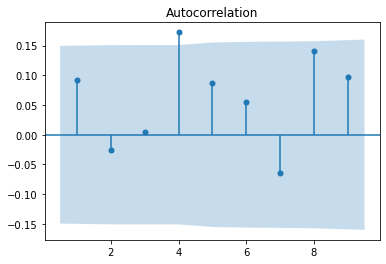

In [87]:
## Step 1: ARMA Model for the Mean with Return Diagnostic (PACF->p; ACF->q)
lags=np.arange(1,10,1)
plot_pacf(obpi_rets,lags=lags)
plot_acf(obpi_rets,lags=lags)
plt.show()

In [88]:
# p-value Q-test
garch_qtest=sm.stats.acorr_ljungbox(obpi_rets, lags=[10], boxpierce=True)
p_val_qtest = garch_qtest[3]
print("p-value Q-test =",p_val_qtest)

p-value Q-test = [0.04638793]


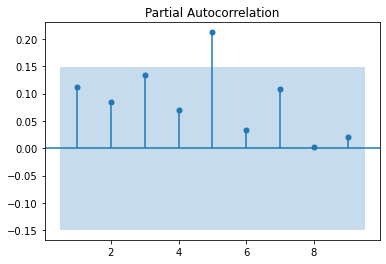

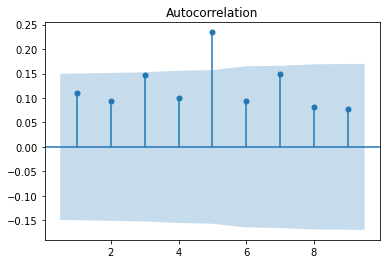

In [89]:
at = obpi_rets - np.mean(obpi_rets)
## Step 2: GARCH Model for the Variance
# Step 2.a: PACF Squared Residuals
plot_pacf(at**2,lags=lags)
plot_acf(at**2,lags=lags)
plt.show()

In [90]:
# Step 2.b: Model Selection with Information Criteria: AIC + BIC
out_garch_aic=np.zeros((2,2))
out_garch_bic=np.zeros((2,2))
for order_s in range(1,3,1):
    for order_q in range(1,3,1):
        print(order_q)
        garch = arch_model(at, mean='Zero', vol='GARCH', p=order_s, o=0, q=order_q, rescale=False)
        garch_result = garch.fit()
        out_garch_aic[order_s-1,order_q-1] = garch_result.aic/len(obpi_rets)
        out_garch_bic[order_s-1,order_q-1] = garch_result.bic/len(obpi_rets)
garch=arch_model(at,p=1,q=1,o=0, mean='Zero', vol='GARCH')
garch_result = garch.fit()

1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 246.60777106355437
Iteration:      2,   Func. Count:     14,   Neg. LLF: -146.26672126298422
Iteration:      3,   Func. Count:     20,   Neg. LLF: -251.92175935009118
Iteration:      4,   Func. Count:     25,   Neg. LLF: -255.8380355816621
Iteration:      5,   Func. Count:     29,   Neg. LLF: -255.83191291706166
Iteration:      6,   Func. Count:     34,   Neg. LLF: -255.83920841304587
Iteration:      7,   Func. Count:     38,   Neg. LLF: -255.83939111560704
Iteration:      8,   Func. Count:     41,   Neg. LLF: -255.8393913104843
Optimization terminated successfully    (Exit mode 0)
            Current function value: -255.83939111560704
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8
2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 113.74446093619036
Iteration:      2,   Func. Count:     17,   Neg. LLF: -123.02163149260204
Iteration:      3,   Func. Count:     23,   Neg. LL

In [91]:
## Step 3: GARCH summary
garch_summary = garch_result.summary()
garch_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:           OBPI Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.006
Vol Model:                      GARCH   Log-Likelihood:                255.839
Distribution:                  Normal   AIC:                          -505.679
Method:            Maximum Likelihood   BIC:                          -496.236
                                        No. Observations:                  172
Date:                Fri, May 20 2022   Df Residuals:                      172
Time:                        21:39:32   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.1217e-04  6.377e-05      1.759  7.860e-02 [-1.283e-05,2.372e-04]
alpha[1]       0.2359  9.873e-02      2.390  1.687e-02    [4.242e-02,  0.429]
beta[1]        0.7641  6.961e-02     10.977  4.924e-28      [  0.628,  0.900]
=============================================================================

Covariance estimator: robust
"""

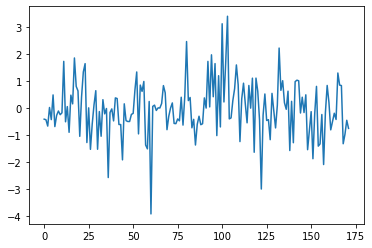

In [92]:
# Step 3.a: GARCH std residuals
garch_std_resid=garch_result._resid/garch_result._volatility
plt.plot(garch_std_resid)
plt.show()

In [93]:
# Step 3.b: Normality Test of Standardized Residuals with Jarque-Bera
jb_stat = stats.jarque_bera(garch_std_resid)
kurt_stat = stats.kurtosis(garch_std_resid)
print("JB Statistics =", jb_stat)
print("Kurtosis Statistics =",kurt_stat)

JB Statistics = Jarque_beraResult(statistic=23.21775368563296, pvalue=9.085081886239799e-06)
Kurtosis Statistics = 1.7999128403087123


In [94]:
# Step 3.c: Normality Test of Standardized Residuals with Ljung-Box
garch_qtest_resid=sm.stats.acorr_ljungbox(garch_std_resid, lags=[10], boxpierce=True)
p_val_qtest_res = garch_qtest_resid[3]
garch_qtest_squared_resid=sm.stats.acorr_ljungbox(garch_std_resid**2, lags=[10], boxpierce=True)
p_val_qtest_sqres= garch_qtest_squared_resid[3]
print("p-value Q-test Residuals =", p_val_qtest_res)
print("p-value Q-test Squared Residuals =", p_val_qtest_sqres)

p-value Q-test Residuals = [0.47417005]
p-value Q-test Squared Residuals = [0.8962472]


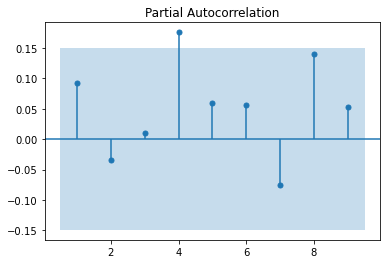

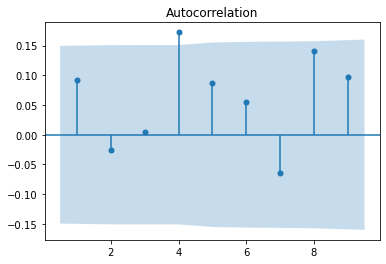

In [95]:
yh=garch_result._resid
plot_pacf(yh,lags=lags)
plot_acf(yh,lags=lags)
plt.show()

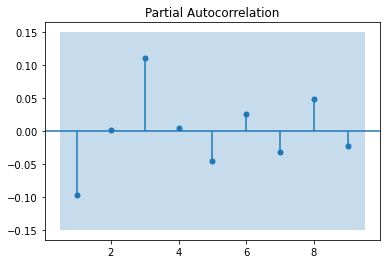

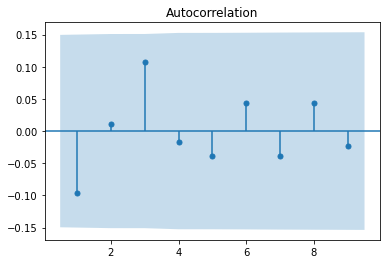

In [96]:
plot_pacf(garch_std_resid**2,lags=lags)
plot_acf(garch_std_resid**2,lags=lags)
plt.show()

In [97]:
# Simulate GARCH Volatility for the future
garch_sim = garch_result.forecast(horizon=52, reindex = False)
std_garch = (np.sqrt(garch_sim.variance.values[-1,:]))*np.sqrt(52)
obpi_vol = np.float64(std_garch[-1])
round(obpi_vol,4)

0.6736

## Evolution of PI Strategies: OBPI subject to price jumps

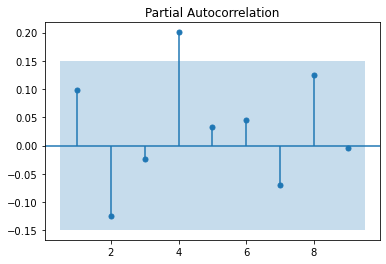

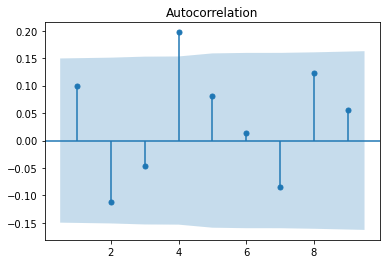

In [98]:
## Step 1: ARMA Model for the Mean with Return Diagnostic (PACF->p; ACF->q)
lags=np.arange(1,10,1)
plot_pacf(obpi_rets_ev,lags=lags)
plot_acf(obpi_rets_ev,lags=lags)
plt.show()

In [99]:
# p-value Q-test
garch_qtest=sm.stats.acorr_ljungbox(obpi_rets_ev, lags=[10], boxpierce=True)
p_val_qtest = garch_qtest[3]
print("p-value Q-test =",p_val_qtest)

p-value Q-test = [0.00686286]


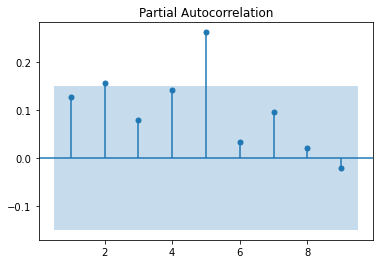

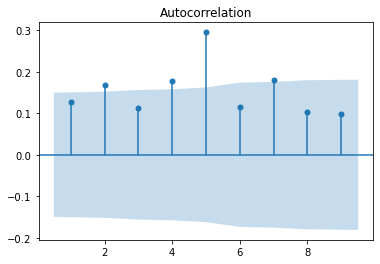

In [100]:
at = obpi_rets_ev - np.mean(obpi_rets_ev)
## Step 2: GARCH Model for the Variance
# Step 2.a: PACF Squared Residuals
plot_pacf(at**2,lags=lags)
plot_acf(at**2,lags=lags)
plt.show()

In [101]:
# Step 2.b: Model Selection with Information Criteria: AIC + BIC
out_garch_aic=np.zeros((2,2))
out_garch_bic=np.zeros((2,2))
for order_s in range(1,3,1):
    for order_q in range(1,3,1):
        print(order_q)
        garch = arch_model(at, mean='Zero', vol='GARCH', p=order_s, o=0, q=order_q, rescale=False)
        garch_result = garch.fit()
        out_garch_aic[order_s-1,order_q-1] = garch_result.aic/len(obpi_rets_ev)
        out_garch_bic[order_s-1,order_q-1] = garch_result.bic/len(obpi_rets_ev)
garch=arch_model(at,p=1,q=1,o=0, mean='Zero', vol='GARCH')
garch_result = garch.fit()

1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2361539.422257726
Iteration:      2,   Func. Count:     10,   Neg. LLF: -239.561976153268
Iteration:      3,   Func. Count:     17,   Neg. LLF: -259.19056763175354
Iteration:      4,   Func. Count:     22,   Neg. LLF: -288.85356713904173
Iteration:      5,   Func. Count:     27,   Neg. LLF: -297.41224777934826
Iteration:      6,   Func. Count:     31,   Neg. LLF: -297.4172751858281
Iteration:      7,   Func. Count:     35,   Neg. LLF: -297.42589921590513
Iteration:      8,   Func. Count:     39,   Neg. LLF: -297.4259052526194
Iteration:      9,   Func. Count:     42,   Neg. LLF: -297.4259057420803
Optimization terminated successfully    (Exit mode 0)
            Current function value: -297.4259052526194
            Iterations: 9
            Function evaluations: 42
            Gradient evaluations: 9
2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3410194.6838735044
Iteration:      2,   Func. Count:     12,   Neg. LLF: -2

In [102]:
## Step 3: GARCH summary
garch_summary = garch_result.summary()
garch_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:           OBPI Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.006
Vol Model:                      GARCH   Log-Likelihood:                297.426
Distribution:                  Normal   AIC:                          -588.852
Method:            Maximum Likelihood   BIC:                          -579.409
                                        No. Observations:                  172
Date:                Fri, May 20 2022   Df Residuals:                      172
Time:                        21:39:34   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      5.9183e-05  3.638e-05      1.627      0.104 [-1.211e-05,1.305e-04]
alpha[1]       0.2732      0.142      1.923  5.444e-02   [-5.203e-03,  0.552]
beta[1]        0.7268      0.109      6.658  2.781e-11      [  0.513,  0.941]
=============================================================================

Covariance estimator: robust
"""

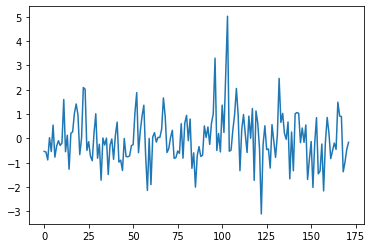

In [103]:
# Step 3.a: GARCH std residuals
garch_std_resid=garch_result._resid/garch_result._volatility
plt.plot(garch_std_resid)
plt.show()

In [104]:
# Step 3.b: Normality Test of Standardized Residuals with Jarque-Bera
jb_stat = stats.jarque_bera(garch_std_resid)
kurt_stat = stats.kurtosis(garch_std_resid)
print("JB Statistics =", jb_stat)
print("Kurtosis Statistics =",kurt_stat)

JB Statistics = Jarque_beraResult(statistic=78.09477480945087, pvalue=0.0)
Kurtosis Statistics = 2.9305228415492808


In [105]:
# Step 3.c: Normality Test of Standardized Residuals with Ljung-Box
garch_qtest_resid=sm.stats.acorr_ljungbox(garch_std_resid, lags=[10], boxpierce=True)
p_val_qtest_res = garch_qtest_resid[3]
garch_qtest_squared_resid=sm.stats.acorr_ljungbox(garch_std_resid**2, lags=[10], boxpierce=True)
p_val_qtest_sqres= garch_qtest_squared_resid[3]
print("p-value Q-test Residuals =", p_val_qtest_res)
print("p-value Q-test Squared Residuals =", p_val_qtest_sqres)

p-value Q-test Residuals = [0.20900673]
p-value Q-test Squared Residuals = [0.30305952]


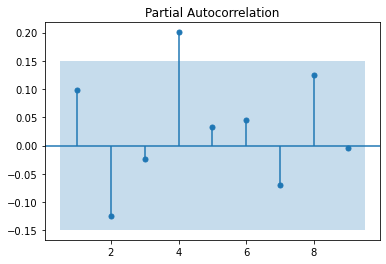

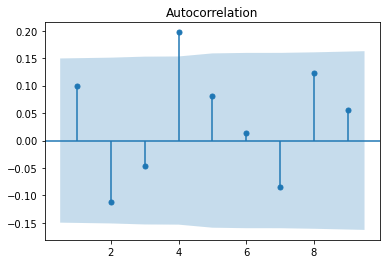

In [106]:
yh=garch_result._resid
plot_pacf(yh,lags=lags)
plot_acf(yh,lags=lags)
plt.show()

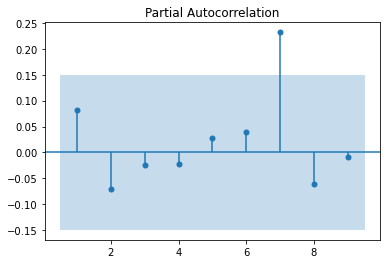

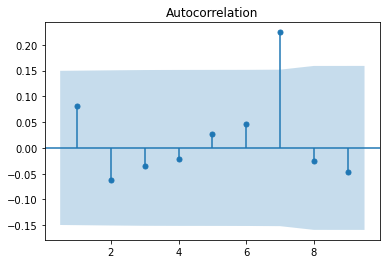

In [107]:
plot_pacf(garch_std_resid**2,lags=lags)
plot_acf(garch_std_resid**2,lags=lags)
plt.show()

In [108]:
# Simulate GARCH Volatility for the future
garch_sim = garch_result.forecast(horizon=52, reindex = False)
std_garch = (np.sqrt(garch_sim.variance.values[-1,:]))*np.sqrt(52)
obpi_vol_ev = np.float64(std_garch[-1])
round(obpi_vol_ev,4)

0.5181

## CPPI

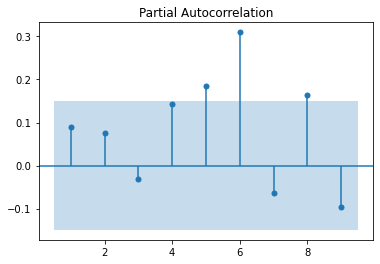

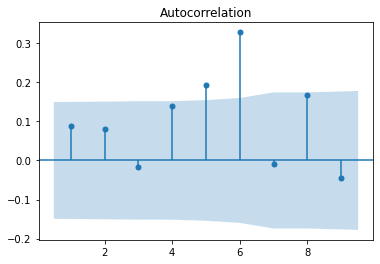

In [109]:
## Step 1: ARMA Model for the Mean with Return Diagnostic (PACF->p; ACF->q)
lags=np.arange(1,10,1)
plot_pacf(cppi_rets,lags=lags)
plot_acf(cppi_rets,lags=lags)
plt.show()

In [110]:
# p-value Q-test
garch_qtest=sm.stats.acorr_ljungbox(cppi_rets, lags=[10], boxpierce=True)
p_val_qtest = garch_qtest[3]
print("p-value Q-test =",p_val_qtest)

p-value Q-test = [5.57505636e-05]


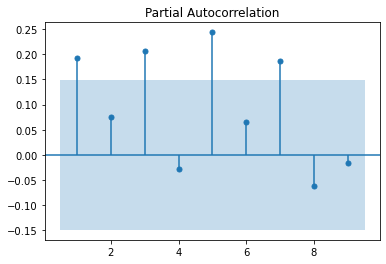

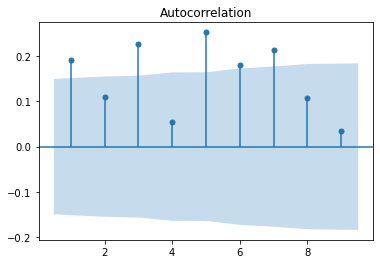

In [111]:
at = cppi_rets - np.mean(cppi_rets)
## Step 2: GARCH Model for the Variance
# Step 2.a: PACF Squared Residuals
plot_pacf(at**2,lags=lags)
plot_acf(at**2,lags=lags)
plt.show()

In [112]:
# Step 2.b: Model Selection with Information Criteria: AIC + BIC
out_garch_aic=np.zeros((2,2))
out_garch_bic=np.zeros((2,2))
for order_s in range(1,3,1):
    for order_q in range(1,3,1):
        print(order_q)
        garch = arch_model(at, mean='Zero', vol='GARCH', p=order_s, o=0, q=order_q, rescale=False)
        garch_result = garch.fit()
        out_garch_aic[order_s-1,order_q-1] = garch_result.aic/len(cppi_rets)
        out_garch_bic[order_s-1,order_q-1] = garch_result.bic/len(cppi_rets)
garch=arch_model(at,p=1,q=1,o=0, mean='Zero', vol='GARCH')
garch_result = garch.fit()

1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -331.16928119986386
Optimization terminated successfully    (Exit mode 0)
            Current function value: -331.169282494616
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -322.8228341372061
Optimization terminated successfully    (Exit mode 0)
            Current function value: -322.8228370435898
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -331.2929539212788
Optimization terminated successfully    (Exit mode 0)
            Current function value: -331.29295556243915
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
2
Iteration:      1,   Func. Count:      6,   Neg. LLF: -322.56743411698005
Optimization terminated successfully    (Exit mode 0)
            Current fun

In [113]:
## Step 3: GARCH summary
garch_summary = garch_result.summary()
garch_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:           CPPI Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.006
Vol Model:                      GARCH   Log-Likelihood:                331.169
Distribution:                  Normal   AIC:                          -656.339
Method:            Maximum Likelihood   BIC:                          -646.896
                                        No. Observations:                  172
Date:                Fri, May 20 2022   Df Residuals:                      172
Time:                        21:39:37   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.3618e-05  7.356e-05      0.865      0.387 [-8.055e-05,2.078e-04]
alpha[1]       0.2000  6.684e-02      2.992  2.769e-03    [6.900e-02,  0.331]
beta[1]        0.7800  4.629e-02     16.850  1.045e-63      [  0.689,  0.871]
=============================================================================

Covariance estimator: robust
"""

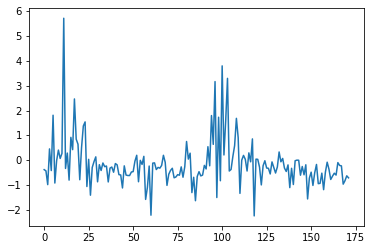

In [114]:
# Step 3.a: GARCH std residuals
garch_std_resid=garch_result._resid/garch_result._volatility
plt.plot(garch_std_resid)
plt.show()

In [115]:
# Step 3.b: Normality Test of Standardized Residuals with Jarque-Bera
jb_stat = stats.jarque_bera(garch_std_resid)
kurt_stat = stats.kurtosis(garch_std_resid)
print("JB Statistics =", jb_stat)
print("Kurtosis Statistics =",kurt_stat)

JB Statistics = Jarque_beraResult(statistic=940.9264237688046, pvalue=0.0)
Kurtosis Statistics = 10.36909590757996


In [116]:
# Step 3.c: Normality Test of Standardized Residuals with Ljung-Box
garch_qtest_resid=sm.stats.acorr_ljungbox(garch_std_resid, lags=[10], boxpierce=True)
p_val_qtest_res = garch_qtest_resid[3]
garch_qtest_squared_resid=sm.stats.acorr_ljungbox(garch_std_resid**2, lags=[10], boxpierce=True)
p_val_qtest_sqres= garch_qtest_squared_resid[3]
print("p-value Q-test Residuals =", p_val_qtest_res)
print("p-value Q-test Squared Residuals =", p_val_qtest_sqres)

p-value Q-test Residuals = [3.91230775e-11]
p-value Q-test Squared Residuals = [0.49862832]


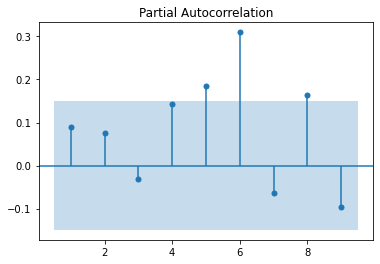

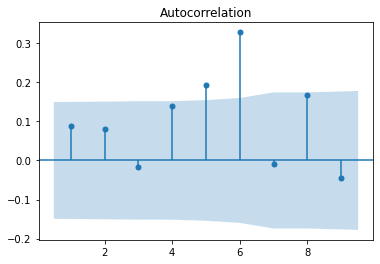

In [117]:
yh=garch_result._resid
plot_pacf(yh,lags=lags)
plot_acf(yh,lags=lags)
plt.show()

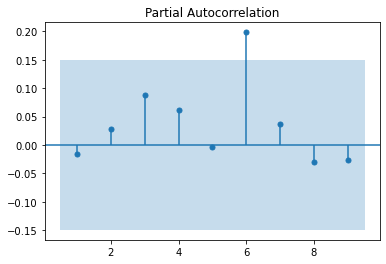

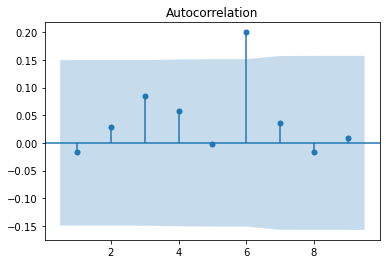

In [118]:
plot_pacf(garch_std_resid**2,lags=lags)
plot_acf(garch_std_resid**2,lags=lags)
plt.show()

In [119]:
# Simulate GARCH Volatility for the future
garch_sim = garch_result.forecast(horizon=52, reindex = False)
std_garch = (np.sqrt(garch_sim.variance.values[-1,:]))*np.sqrt(52)
cppi_vol = np.float64(std_garch[-1])
round(cppi_vol,4)

0.3391

## Evolution of PI Strategies: CPPI subject to price jumps

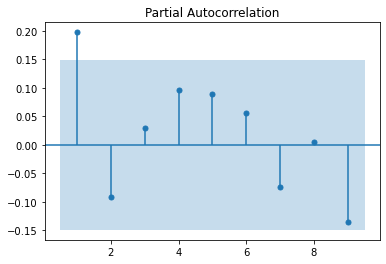

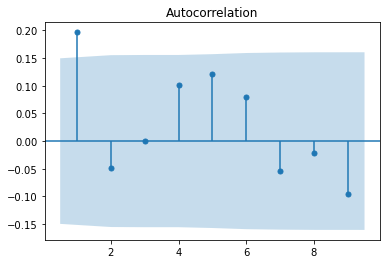

In [120]:
## Step 1: ARMA Model for the Mean with Return Diagnostic (PACF->p; ACF->q)
lags=np.arange(1,10,1)
plot_pacf(cppi_rets_ev,lags=lags)
plot_acf(cppi_rets_ev,lags=lags)
plt.show()

In [121]:
garch_qtest=sm.stats.acorr_ljungbox(cppi_rets_ev, lags=[10], boxpierce=True)
p_val_qtest = garch_qtest[3]
print("p-value Q-test =",p_val_qtest)

p-value Q-test = [0.09995079]


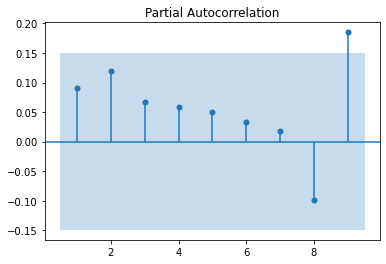

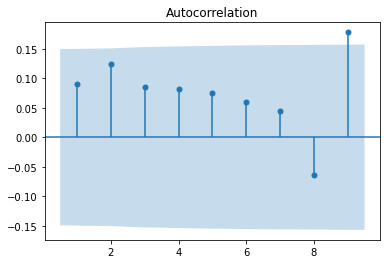

In [122]:
at = cppi_rets_ev - np.mean(cppi_rets_ev)
## Step 2: GARCH Model for the Variance
# Step 2.a: PACF Squared Residuals
plot_pacf(at**2,lags=lags)
plot_acf(at**2,lags=lags)
plt.show()

In [123]:
# Step 2.b: Model Selection with Information Criteria: AIC + BIC
out_garch_aic=np.zeros((2,2))
out_garch_bic=np.zeros((2,2))
for order_s in range(1,3,1):
    for order_q in range(1,3,1):
        print(order_q)
        garch = arch_model(at, mean='Zero', vol='GARCH', p=order_s, o=0, q=order_q, rescale=False)
        garch_result = garch.fit()
        out_garch_aic[order_s-1,order_q-1] = garch_result.aic/len(cppi_rets_ev)
        out_garch_bic[order_s-1,order_q-1] = garch_result.bic/len(cppi_rets_ev)
garch=arch_model(at,p=1,q=1,o=0, mean='Zero', vol='GARCH')
garch_result = garch.fit()

1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 161.04005682052605
Iteration:      2,   Func. Count:     13,   Neg. LLF: -295.27456137044305
Iteration:      3,   Func. Count:     19,   Neg. LLF: -278.86476493914824
Iteration:      4,   Func. Count:     24,   Neg. LLF: -306.19592640241854
Iteration:      5,   Func. Count:     29,   Neg. LLF: -306.1558868886337
Iteration:      6,   Func. Count:     34,   Neg. LLF: -306.2055959992101
Iteration:      7,   Func. Count:     38,   Neg. LLF: -306.20576116566303
Iteration:      8,   Func. Count:     42,   Neg. LLF: -306.2057620566515
Optimization terminated successfully    (Exit mode 0)
            Current function value: -306.2057620566515
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8
2
Iteration:      1,   Func. Count:      6,   Neg. LLF: -174.13046060935642
Iteration:      2,   Func. Count:     15,   Neg. LLF: -296.89278571554894
Iteration:      3,   Func. Count:     22,   Neg. LLF

In [124]:
## Step 3: GARCH summary
garch_summary = garch_result.summary()
garch_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:        CPPI EV Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.006
Vol Model:                      GARCH   Log-Likelihood:                306.206
Distribution:                  Normal   AIC:                          -606.412
Method:            Maximum Likelihood   BIC:                          -596.969
                                        No. Observations:                  172
Date:                Fri, May 20 2022   Df Residuals:                      172
Time:                        21:39:40   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.0382e-04  3.507e-04      0.866      0.386 [-3.836e-04,9.912e-04]
alpha[1]       0.2581      0.404      0.639      0.523      [ -0.534,  1.050]
beta[1]        0.6003      0.466      1.288      0.198      [ -0.313,  1.513]
=============================================================================

Covariance estimator: robust
"""

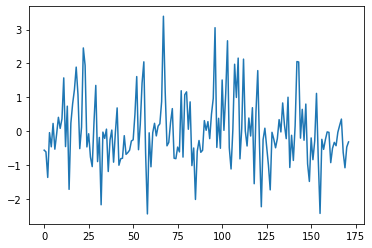

In [125]:
# Step 3.a: GARCH std residuals
garch_std_resid=garch_result._resid/garch_result._volatility
plt.plot(garch_std_resid)
plt.show()

In [126]:
# Step 3.b: Normality Test of Standardized Residuals with Jarque-Bera
jb_stat = stats.jarque_bera(garch_std_resid)
kurt_stat = stats.kurtosis(garch_std_resid)
print("JB Statistics =", jb_stat)
print("Kurtosis Statistics =",kurt_stat)

JB Statistics = Jarque_beraResult(statistic=18.11962888878297, pvalue=0.00011624454441150345)
Kurtosis Statistics = 1.0075193089414594


In [127]:
# Step 3.c: Normality Test of Standardized Residuals with Ljung-Box
garch_qtest_resid=sm.stats.acorr_ljungbox(garch_std_resid, lags=[10], boxpierce=True)
p_val_qtest_res = garch_qtest_resid[3]
garch_qtest_squared_resid=sm.stats.acorr_ljungbox(garch_std_resid**2, lags=[10], boxpierce=True)
p_val_qtest_sqres= garch_qtest_squared_resid[3]
print("p-value Q-test Residuals =", p_val_qtest_res)
print("p-value Q-test Squared Residuals =", p_val_qtest_sqres)

p-value Q-test Residuals = [0.11200365]
p-value Q-test Squared Residuals = [0.84220024]


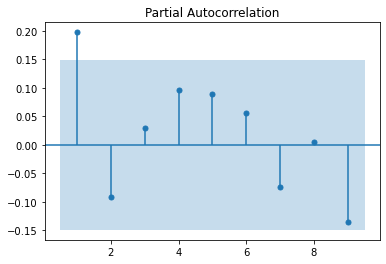

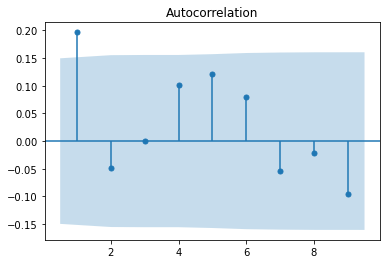

In [128]:
yh=garch_result._resid
plot_pacf(yh,lags=lags)
plot_acf(yh,lags=lags)
plt.show()

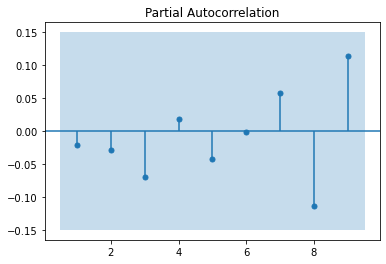

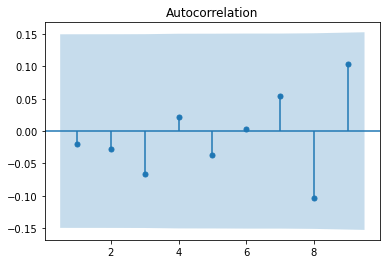

In [129]:
plot_pacf(garch_std_resid**2,lags=lags)
plot_acf(garch_std_resid**2,lags=lags)
plt.show()

In [130]:
# Simulate GARCH Volatility for the future
garch_sim = garch_result.forecast(horizon=52, reindex = False)
std_garch = (np.sqrt(garch_sim.variance.values[-1,:]))*np.sqrt(52)
cppi_vol_ev = np.float64(std_garch[-1])
round(cppi_vol_ev,4)

0.334

# Simulation

## 60/40 Portfolio

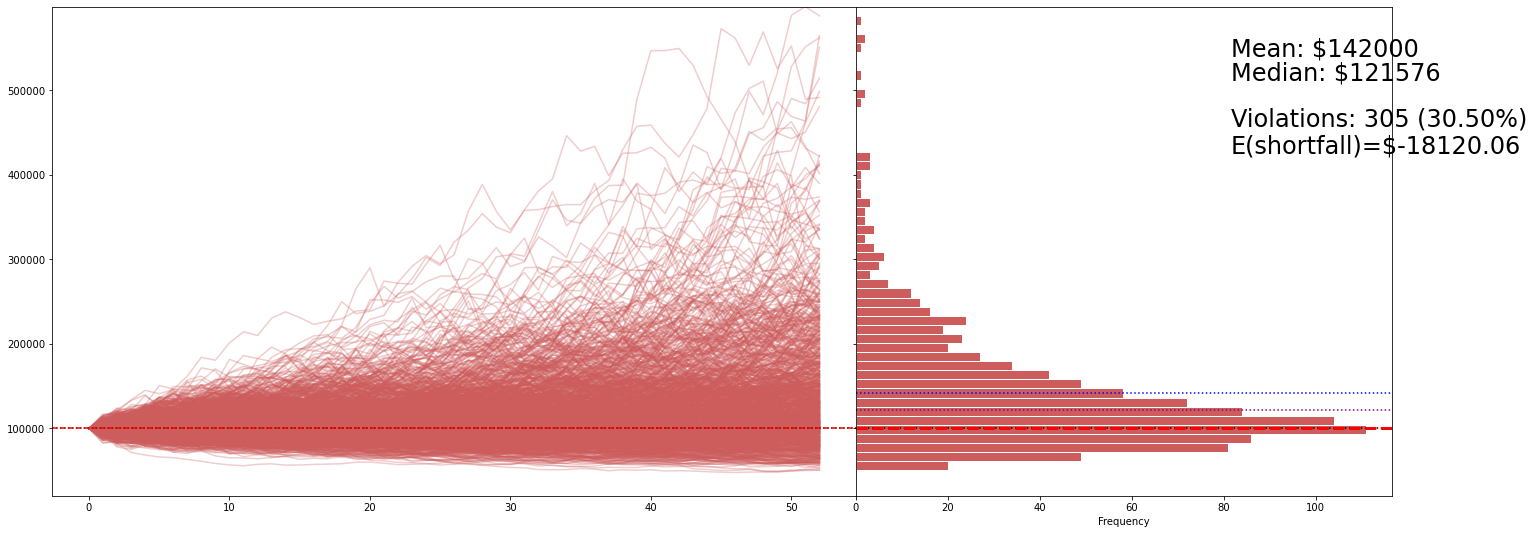

In [131]:
def show_hold(n_scenarios=10000, mu=round(hold_mu,2), sigma=round(hold_vol,2), riskfree_rate=tbill_sim*100, risky_weight=hold_w, periods_per_year=52, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of 60/40 Portfolio
    """
    start = 100000
    sim_rets = gbm(n_scenarios_gbm=n_scenarios, mu_gbm=mu, sigma_gbm=sigma, periods_per_year_gbm=periods_per_year, prices = False, s_0 = start)
    risky_r = pd.DataFrame(sim_rets)
    # Run the "back"-test with simulated returns
    btr = run_hold (risky_r=pd.DataFrame(risky_r), start = start, risky_w=risky_weight, riskfree_rate=riskfree_rate/100, periods_per_year = periods_per_year)
    show_hold.wealth = btr["Buy-and-Hold"]
        
    # Calculate terminal wealth stats
    y_max=show_hold.wealth.values.max()*y_max/100
    terminal_wealth = show_hold.wealth.iloc[-1]
    
    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    failure_mask = np.less(terminal_wealth, start*(1+riskfree_rate/100))
    n_failures = failure_mask.sum()
    p_fail = n_failures/n_scenarios

    e_shortfall = np.dot(terminal_wealth-start*(1+riskfree_rate/100), failure_mask)/n_failures if n_failures > 0 else 0.0

    # Plot
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.subplots_adjust(wspace=0.0)
    
    show_hold.wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*(1+riskfree_rate/100), ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=tw_mean, ls=":", color="blue")
    hist_ax.axhline(y=tw_median, ls=":", color="purple")
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.7, .9),xycoords='axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.7, .85),xycoords='axes fraction', fontsize=24)
    if (riskfree_rate > 0.01):
        hist_ax.axhline(y=start*(1+riskfree_rate/100), ls="--", color="red", linewidth=3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", xy=(.7, .7), xycoords='axes fraction', fontsize=24)

hold_controls = widgets.interactive(show_hold,
                               n_scenarios=widgets.IntSlider(min=1, max=10000, step=5, value=1000), 
                               mu=(0., +3., .01),
                               sigma=(0, +1., .04),
                               riskfree_rate=(0, .2, .001),
                               risky_weight = (0,+1.,0.1),
                               periods_per_year=widgets.IntSlider(min=1, max=252, step=1, value=52,
                                                      description="Rebals/Year"),
                               y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                      description="Zoom Y Axis")
)
display (hold_controls)

In [132]:
hold_sim_rets = show_hold.wealth.pct_change(axis=0).dropna()
hold_sim_rets.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1,0.088498,0.111831,-0.073449,0.051483,0.019061,0.052359,0.027582,0.039033,-0.009752,0.055161,...,-0.005386,0.142013,0.006027,-0.001223,-0.068457,0.069039,0.020584,0.007853,0.019628,-0.071545
2,-0.056044,-0.017110,-0.027202,0.015126,0.021728,0.033631,0.072861,-0.068531,0.075850,-0.096562,...,-0.005841,0.051293,0.039257,0.016817,0.086202,-0.012553,-0.002828,0.003940,0.035899,-0.025204
3,0.028536,0.073793,-0.026339,-0.053697,-0.007842,-0.106592,-0.065527,-0.014397,-0.035358,-0.008207,...,0.017511,0.046138,0.031887,0.102495,0.008891,-0.071168,-0.007049,0.107307,0.073534,-0.022396
4,0.035590,0.048681,-0.059099,0.023292,-0.026578,-0.121215,0.007120,0.042027,-0.069514,0.048358,...,0.018679,0.019993,-0.031394,0.016998,-0.013093,0.018003,-0.000031,0.008725,0.047297,0.037428
5,-0.032721,0.052920,0.058592,-0.042181,-0.073484,0.035092,-0.023920,0.079240,-0.023238,-0.026308,...,0.012648,-0.038130,0.018722,0.014777,-0.034792,-0.008988,-0.029075,0.038209,0.085294,0.022517


In [133]:
box_pierce(hold_sim_rets)

,Q,p(Q)
CMC rets,0.021172,0.884312


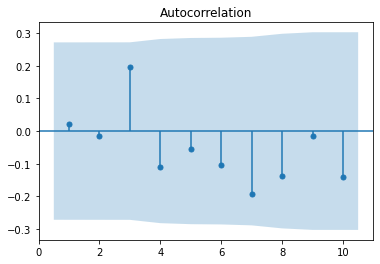

In [134]:
correlogram_plot(hold_sim_rets)

## OBPI

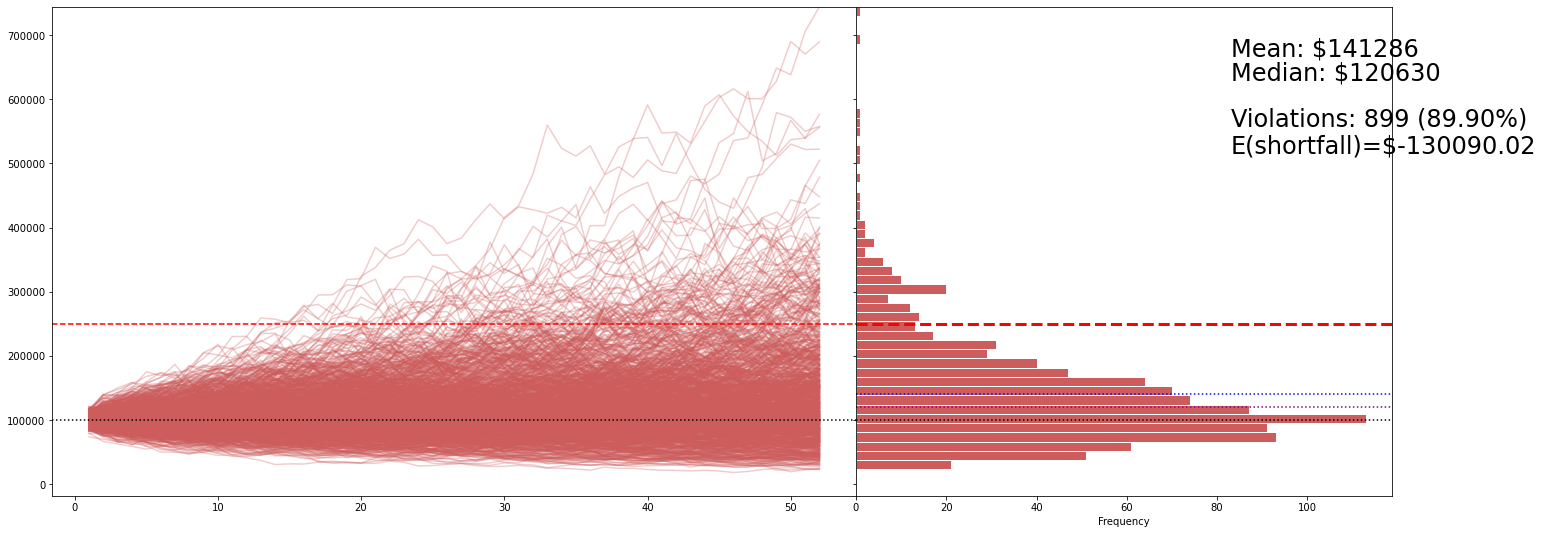

In [135]:
def show_obpi(n_scenarios=10000, mu=round(obpi_mu,2), sigma=round(obpi_vol,2), K = obpi_k, riskfree_rate=tbill_sim*100, periods_per_year=52, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of OBPI
    """
    start = 100000
    sim_prices = gbm(n_scenarios_gbm=n_scenarios, mu_gbm=mu, sigma_gbm=sigma, periods_per_year_gbm=periods_per_year, prices = True, s_0 = start)
    risky_p = pd.DataFrame(sim_prices)
    # Run the "back"-test with simulated prices
    btr = run_obpi(prices=pd.DataFrame(risky_p),r=riskfree_rate/100, K=K, start=start, periods_per_year=periods_per_year, sigma = sigma)
    show_obpi.wealth = btr["Wealth"]
        
    # Calculate terminal wealth stats
    y_max=show_obpi.wealth.values.max()*y_max/100
    terminal_wealth = show_obpi.wealth.iloc[-1]
    
    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    failure_mask = np.less(terminal_wealth, (K / 100) * start)
    n_failures = failure_mask.sum()
    p_fail = n_failures/n_scenarios

    e_shortfall = np.dot(terminal_wealth-(K / 100) * start, failure_mask)/n_failures if n_failures > 0 else 0.0

    # Plot
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.subplots_adjust(wspace=0.0)
    
    show_obpi.wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=(K / 100) * start, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=tw_mean, ls=":", color="blue")
    hist_ax.axhline(y=tw_median, ls=":", color="purple")
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.7, .9),xycoords='axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.7, .85),xycoords='axes fraction', fontsize=24)
    if (K > 0.01):
        hist_ax.axhline(y=(K / 100) * start, ls="--", color="red", linewidth=3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", xy=(.7, .7), xycoords='axes fraction', fontsize=24)

obpi_controls = widgets.interactive(show_obpi,
                               n_scenarios=widgets.IntSlider(min=1, max=10000, step=5, value=1000), 
                               mu=(0., +3., .01),
                               sigma=(0, +1., .04),
                               riskfree_rate=(0, .2, .001),
                               K=(1, 1000, 5),
                               periods_per_year=widgets.IntSlider(min=1, max=252, step=1, value=52,
                                                      description="Rebals/Year"),
                               y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                      description="Zoom Y Axis")
)
display (obpi_controls)

In [136]:
obpi_sim_rets = show_obpi.wealth.pct_change(axis=0).dropna()
obpi_sim_rets.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2,0.006754,-0.055006,0.018002,0.107311,0.074569,-0.041633,0.041174,0.099531,-0.026420,-0.031783,...,0.098475,-0.011197,0.007689,-0.171614,0.046323,-0.051441,-0.077594,-0.039748,0.122041,0.047752
3,0.014537,-0.142416,0.168133,-0.128760,-0.018278,0.114442,-0.049327,0.109110,-0.047666,-0.181806,...,0.043685,-0.080137,-0.045981,0.042923,-0.075941,-0.061167,0.067016,0.007429,-0.116960,-0.045920
4,0.039870,-0.008441,-0.004437,-0.046662,-0.037387,-0.096652,0.029861,-0.046886,-0.035373,0.150762,...,-0.045848,0.024160,-0.139073,-0.061106,0.026684,-0.066954,0.018957,0.086642,-0.051259,-0.096285
5,-0.028140,0.016972,0.211117,-0.020757,0.042811,0.084317,-0.082580,-0.046237,0.013924,-0.037164,...,-0.044523,0.046866,0.098645,-0.105948,-0.138155,0.096478,0.003098,0.046864,-0.045478,-0.100358
6,-0.047888,-0.047896,-0.026031,-0.152966,0.028000,-0.015566,-0.032231,-0.050835,-0.028769,0.023403,...,-0.142596,-0.077593,-0.029131,0.039049,-0.087732,0.060400,0.061759,-0.051011,-0.037527,0.121146


In [137]:
box_pierce(obpi_sim_rets)

,Q,p(Q)
CMC rets,2.684278,0.101343


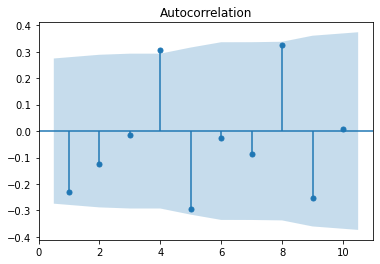

In [138]:
correlogram_plot(obpi_sim_rets)

## Evolution of PI Strategies: OBPI subject to price jumps

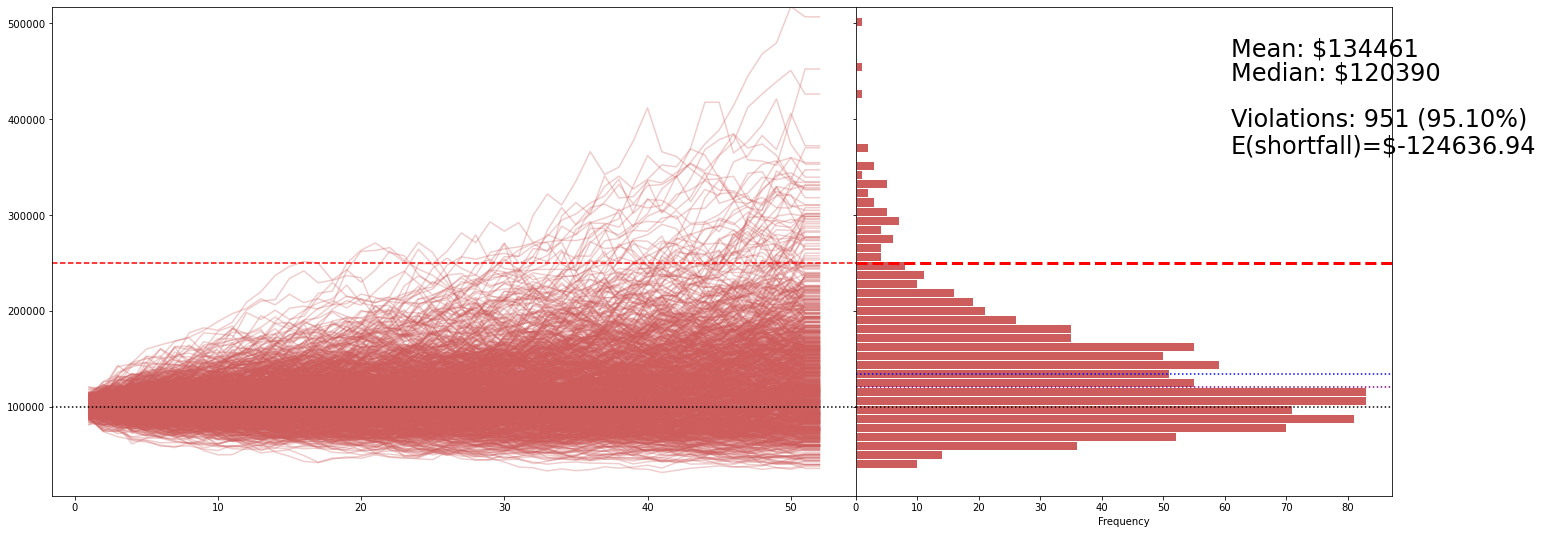

In [139]:
def show_obpi_ev(n_scenarios=10000, mu=round(obpi_mu_ev,2), sigma=round(obpi_vol_ev,2), K = obpi_k_ev, riskfree_rate=tbill_sim*100, periods_per_year=52, y_max=100, jump_pct = 0.1):
    """
    Plot the results of a Monte Carlo Simulation of OBPI
    """
    start = 100000
    sim_prices = gbm(n_scenarios_gbm=n_scenarios, mu_gbm=mu, sigma_gbm=sigma, periods_per_year_gbm=periods_per_year, prices = True, s_0 = start)
    risky_p = pd.DataFrame(sim_prices)
    # Run the "back"-test with simulated prices
    btr = run_obpi(prices=pd.DataFrame(risky_p),r=riskfree_rate/100, K=K, start=start, periods_per_year=periods_per_year, sigma = sigma, jump_pct = jump_pct)
    show_obpi_ev.wealth = btr["Wealth"]
        
    # Calculate terminal wealth stats
    y_max=show_obpi_ev.wealth.values.max()*y_max/100
    terminal_wealth = show_obpi_ev.wealth.iloc[-1]
    
    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    failure_mask = np.less(terminal_wealth, (K / 100) * start)
    n_failures = failure_mask.sum()
    p_fail = n_failures/n_scenarios

    e_shortfall = np.dot(terminal_wealth-(K / 100) * start, failure_mask)/n_failures if n_failures > 0 else 0.0

    # Plot
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.subplots_adjust(wspace=0.0)
    
    show_obpi_ev.wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=(K / 100) * start, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=tw_mean, ls=":", color="blue")
    hist_ax.axhline(y=tw_median, ls=":", color="purple")
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.7, .9),xycoords='axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.7, .85),xycoords='axes fraction', fontsize=24)
    if (K > 0.01):
        hist_ax.axhline(y=(K / 100) * start, ls="--", color="red", linewidth=3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", xy=(.7, .7), xycoords='axes fraction', fontsize=24)

obpi_ev_controls = widgets.interactive(show_obpi_ev,
                               n_scenarios=widgets.IntSlider(min=1, max=10000, step=5, value=1000), 
                               mu=(0., +3., .01),
                               sigma=(0, +1., .04),
                               riskfree_rate=(0, .2, .001),
                               jump_pct=(0, 1, .01),
                               K=(1, 1000, 5),
                               periods_per_year=widgets.IntSlider(min=1, max=252, step=1, value=52,
                                                      description="Rebals/Year"),
                               y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                      description="Zoom Y Axis")
)
display (obpi_ev_controls)

In [140]:
obpi_sim_rets_ev = show_obpi_ev.wealth.pct_change(axis=0).dropna()
obpi_sim_rets_ev.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2,0.049355,-0.105549,-0.081122,0.018273,0.027478,-0.023773,0.059243,0.046102,-0.021847,-0.056356,...,0.072714,0.067635,-0.005280,0.021809,-0.093650,-0.052849,0.080557,-0.035434,0.071720,0.040331
3,0.082104,0.046789,0.070045,-0.022224,0.066759,-0.048477,-0.070706,-0.072682,0.019036,0.043726,...,0.002915,-0.109972,0.114632,0.042694,0.055198,-0.027161,-0.081686,0.030648,0.075330,0.003472
4,0.053176,-0.032096,-0.008468,0.097142,0.023674,-0.011481,0.011882,-0.097185,-0.153371,0.043269,...,0.066395,0.122532,0.112729,-0.043558,-0.049801,0.046340,0.051821,0.006224,-0.094077,-0.043576
5,-0.001398,-0.009368,-0.000896,-0.062751,-0.081460,0.018510,-0.023047,0.049050,0.053355,0.027190,...,-0.026020,-0.006127,0.010499,0.003519,-0.023425,-0.017593,-0.030368,0.002311,0.032897,0.002989
6,-0.038305,0.068511,-0.076406,0.049625,-0.049433,-0.043928,0.029352,-0.085420,-0.108465,-0.062278,...,0.043014,0.050680,0.000178,-0.082688,-0.098041,-0.117306,0.012524,-0.073927,-0.042025,0.005069


In [141]:
box_pierce(obpi_sim_rets_ev)

,Q,p(Q)
CMC rets,0.13917,0.709107


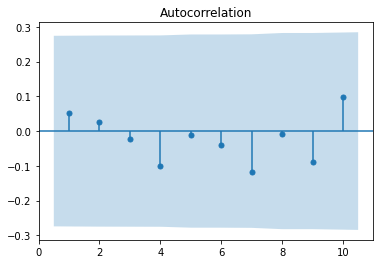

In [142]:
correlogram_plot(obpi_sim_rets_ev)

## CPPI

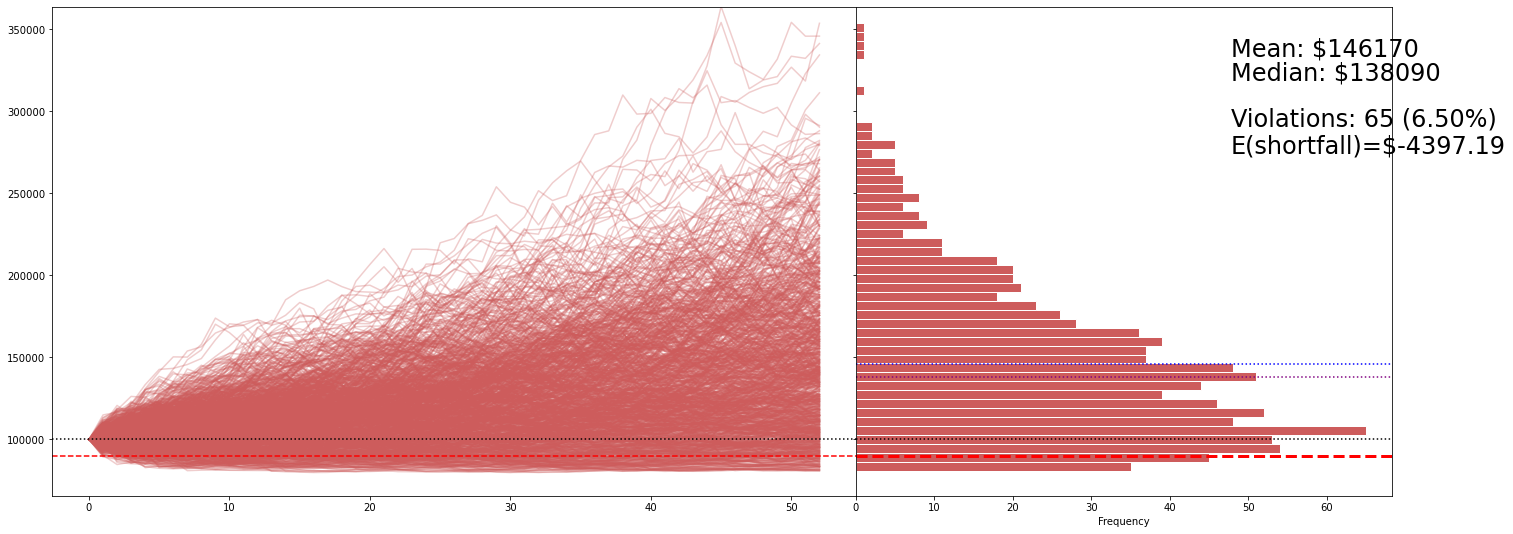

In [143]:
def show_cppi(n_scenarios=10000, mu=round(cppi_mu,2), sigma=round(cppi_vol,2), m=cppi_m, floor=cppi_floor, riskfree_rate=tbill_sim*100, drawdown = cppi_dd, periods_per_year=52, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100000
    sim_rets = gbm(n_scenarios_gbm=n_scenarios, mu_gbm=mu, sigma_gbm=sigma, periods_per_year_gbm=periods_per_year, prices = False, s_0 = start)
    risky_r = pd.DataFrame(sim_rets)
    # Run the "back"-test with simulated returns
    btr = run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate/100, m=m, start=start, floor=floor, periods_per_year=periods_per_year, drawdown = drawdown)
    show_cppi.wealth = btr["Wealth"]
        
    # Calculate terminal wealth stats
    y_max=show_cppi.wealth.values.max()*y_max/100
    terminal_wealth = show_cppi.wealth.iloc[-1]
    
    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    failure_mask = np.less(terminal_wealth, start*floor)
    n_failures = failure_mask.sum()
    p_fail = n_failures/n_scenarios

    e_shortfall = np.dot(terminal_wealth-start*floor, failure_mask)/n_failures if n_failures > 0 else 0.0

    # Plot
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.subplots_adjust(wspace=0.0)
    
    show_cppi.wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=tw_mean, ls=":", color="blue")
    hist_ax.axhline(y=tw_median, ls=":", color="purple")
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.7, .9),xycoords='axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.7, .85),xycoords='axes fraction', fontsize=24)
    if (floor > 0.01):
        hist_ax.axhline(y=start*floor, ls="--", color="red", linewidth=3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", xy=(.7, .7), xycoords='axes fraction', fontsize=24)

cppi_controls = widgets.interactive(show_cppi,
                               n_scenarios=widgets.IntSlider(min=1, max=10000, step=5, value=1000), 
                               mu=(0., +3., .01),
                               sigma=(0, +1., .04),
                               floor=(0, 2, .1),
                               m=(1, 10, .5),
                               riskfree_rate=(0, .2, .001),
                               drawdown=(0, 1, .01),
                               periods_per_year=widgets.IntSlider(min=1, max=252, step=1, value=52,
                                                      description="Rebals/Year"),
                               y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                      description="Zoom Y Axis")
)
display (cppi_controls)

In [144]:
cppi_sim_rets = show_cppi.wealth.pct_change(axis=0).dropna()
cppi_sim_rets.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1,-0.048476,0.026442,0.079974,0.018316,0.040267,0.023751,0.027957,0.039469,-0.002256,-0.028492,...,0.010055,-0.000376,0.054574,0.017496,-0.032841,0.003093,0.041980,0.059416,-0.066536,-0.056695
2,0.004835,0.045227,0.032532,0.057637,-0.005091,0.084604,0.068699,0.004664,0.004250,-0.056362,...,0.071901,0.052362,0.030021,0.004202,0.022495,-0.015389,-0.038800,-0.035790,0.069064,0.061326
3,-0.013532,0.021693,0.015216,-0.030280,0.053991,-0.023669,0.020109,0.011460,-0.005337,-0.010707,...,-0.008442,0.031437,-0.000933,-0.019417,0.017603,-0.059867,0.022077,0.014576,-0.005593,0.002870
4,0.001271,-0.014418,0.056398,0.028733,0.111269,0.028078,-0.029161,0.032832,-0.004017,-0.032301,...,-0.027076,0.061334,-0.085941,0.041152,0.047479,-0.005595,0.037429,0.023651,0.010925,-0.029560
5,0.044484,-0.047390,-0.024605,0.011495,0.003748,-0.030632,0.038713,-0.001871,0.005794,-0.025565,...,0.006608,0.006257,-0.033058,0.003045,-0.004530,0.002578,-0.011612,0.041618,-0.042649,-0.031187


In [145]:
box_pierce(cppi_sim_rets)

,Q,p(Q)
CMC rets,0.000006,0.998026


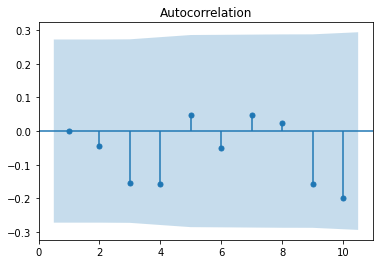

In [146]:
correlogram_plot(cppi_sim_rets)

## Evolution of PI Strategies: CPPI subject to price jumps

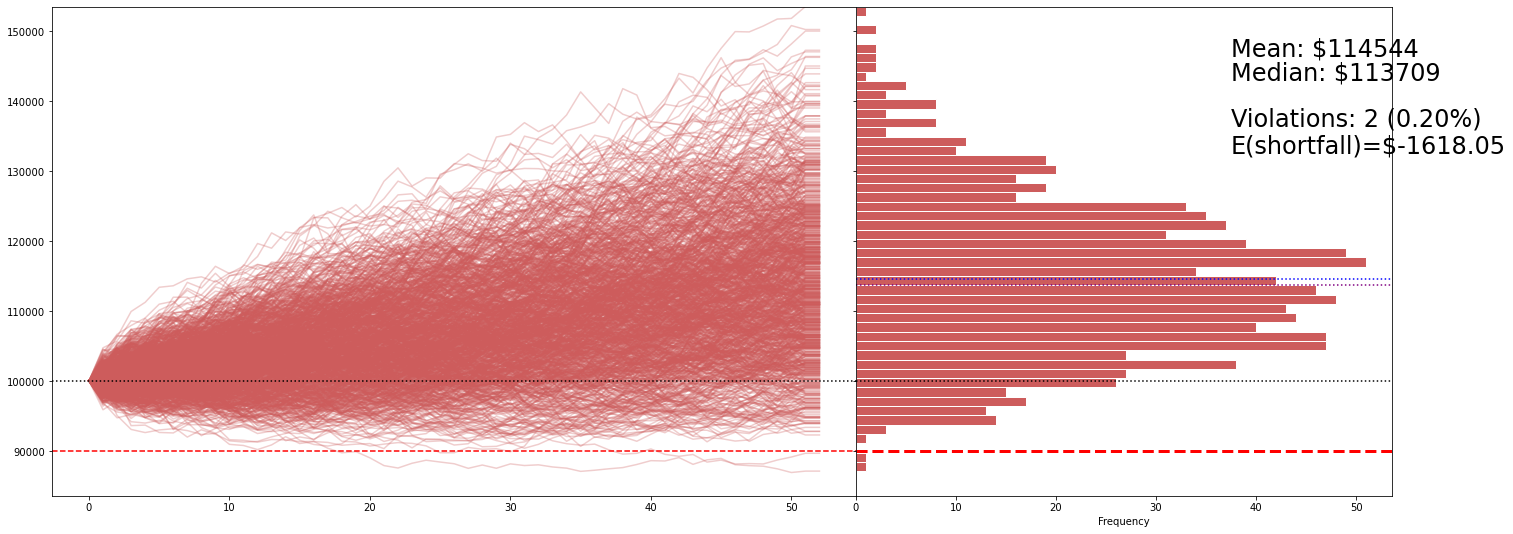

In [147]:
def show_cppi_ev(n_scenarios=10000, mu=round(cppi_mu_ev,2), sigma=round(cppi_vol_ev,2), m=cppi_m_ev, floor=cppi_floor_ev, riskfree_rate=tbill_sim*100, jump_pct = cppi_jp_ev, drawdown = cppi_dd_ev, periods_per_year=52, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI subject to price jumps
    """
    start = 100000
    sim_rets = gbm(n_scenarios_gbm=n_scenarios, mu_gbm=mu, sigma_gbm=sigma, periods_per_year_gbm=periods_per_year, prices = False, s_0 = start)
    risky_r = pd.DataFrame(sim_rets)
    # Run the "back"-test with simulated returns
    btr = run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate/100, m=m, start=start, floor=floor, periods_per_year=periods_per_year, drawdown = drawdown, jump_pct = jump_pct)
    show_cppi_ev.wealth = btr["Wealth"]
        
    # Calculate terminal wealth stats
    y_max=show_cppi_ev.wealth.values.max()*y_max/100
    terminal_wealth = show_cppi_ev.wealth.iloc[-1]
    
    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    failure_mask = np.less(terminal_wealth, start*floor)
    n_failures = failure_mask.sum()
    p_fail = n_failures/n_scenarios

    e_shortfall = np.dot(terminal_wealth-start*floor, failure_mask)/n_failures if n_failures > 0 else 0.0

    # Plot
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.subplots_adjust(wspace=0.0)
    
    show_cppi_ev.wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=tw_mean, ls=":", color="blue")
    hist_ax.axhline(y=tw_median, ls=":", color="purple")
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.7, .9),xycoords='axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.7, .85),xycoords='axes fraction', fontsize=24)
    if (floor > 0.01):
        hist_ax.axhline(y=start*floor, ls="--", color="red", linewidth=3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", xy=(.7, .7), xycoords='axes fraction', fontsize=24)

cppi_ev_controls = widgets.interactive(show_cppi_ev,
                               n_scenarios=widgets.IntSlider(min=1, max=10000, step=5, value=1000), 
                               mu=(0., +3., .01),
                               sigma=(0, +1., .04),
                               floor=(0, 2, .1),
                               m=(1, 10, .5),
                               riskfree_rate=(0, .2, .001),
                               drawdown=(0, 1, .01),
                               jump_pct=(0, 1, .01),
                               periods_per_year=widgets.IntSlider(min=1, max=252, step=1, value=52,
                                                      description="Rebals/Year"),
                               y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                      description="Zoom Y Axis")
)
display (cppi_ev_controls)

In [148]:
cppi_sim_rets_ev = show_cppi_ev.wealth.pct_change(axis=0).dropna()
cppi_sim_rets_ev.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1,-0.024876,0.009769,0.001518,-0.027574,0.000650,0.004485,-0.015469,0.020229,-0.007740,-0.003656,...,0.017334,-0.019171,0.011762,0.003808,-0.010950,-0.001883,0.004223,0.011663,-0.014658,0.030366
2,0.003872,0.008896,0.011976,-0.000063,0.024406,0.000623,-0.010675,0.003541,-0.008852,0.001606,...,-0.000635,0.012901,0.018080,-0.005599,-0.022301,-0.007081,-0.003574,0.035597,-0.008219,-0.003229
3,0.026769,0.000136,-0.005629,0.008060,0.009635,0.007863,-0.014915,-0.014996,-0.011033,0.004474,...,0.014705,-0.005721,0.016583,-0.015333,0.008911,0.014208,-0.007543,0.003273,0.014201,0.026019
4,0.009130,-0.002709,-0.010603,-0.019087,-0.004671,-0.007400,0.018578,-0.010722,-0.015385,0.006993,...,0.018908,-0.009568,-0.000734,-0.000525,-0.003450,-0.022469,-0.000563,-0.006552,0.009757,-0.004667
5,-0.001993,0.009705,-0.008457,0.017434,0.003714,0.007455,-0.001307,0.001157,-0.003408,0.022313,...,-0.008422,-0.023496,0.013368,0.005981,-0.004699,-0.004175,0.004907,-0.013147,0.000316,0.017739


In [149]:
box_pierce(cppi_sim_rets_ev)

,Q,p(Q)
CMC rets,0.21244,0.644862


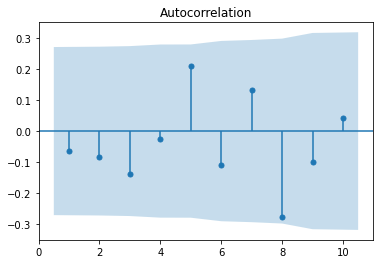

In [150]:
correlogram_plot(cppi_sim_rets_ev)

# Summary statistics for simulation

In [151]:
summary_stats(hold_sim_rets, riskfree_rate= tbill_sim).mean()

Annualized Return          0.420004
Annualized Volatility      0.402228
Semi-Deviation             0.241650
Skewness                  -0.092380
Kurtosis                   3.009500
Historic VaR (5%)          0.082498
Cornish-Fisher VaR (5%)    0.085762
Historic CVaR (5%)         0.105177
Return on VaR              5.391333
Sharpe Ratio               0.912856
Sortino Ratio              1.719829
Calmar Ratio               2.152489
Modified Burke Ratio       5.956093
Max Drawdown              -0.289735
dtype: float64

In [152]:
summary_stats(obpi_sim_rets, riskfree_rate=tbill_sim).mean()

Annualized Return          0.415542
Annualized Volatility      0.566603
Semi-Deviation             0.328697
Skewness                   0.012571
Kurtosis                   2.886188
Historic VaR (5%)          0.116231
Cornish-Fisher VaR (5%)    0.121031
Historic CVaR (5%)         0.144344
Return on VaR              4.500021
Sharpe Ratio               0.746225
Sortino Ratio              1.433248
Calmar Ratio               1.831413
Modified Burke Ratio       4.863456
Max Drawdown              -0.404651
dtype: float64

In [153]:
summary_stats(obpi_sim_rets_ev, riskfree_rate=tbill_sim).mean()

Annualized Return          0.347118
Annualized Volatility      0.434116
Semi-Deviation             0.253171
Skewness                   0.004854
Kurtosis                   2.925603
Historic VaR (5%)          0.088396
Cornish-Fisher VaR (5%)    0.092190
Historic CVaR (5%)         0.110786
Return on VaR              4.862808
Sharpe Ratio               0.817105
Sortino Ratio              1.534693
Calmar Ratio               1.927163
Modified Burke Ratio       5.137154
Max Drawdown              -0.314324
dtype: float64

In [154]:
summary_stats(cppi_sim_rets, riskfree_rate= tbill_sim).mean()

Annualized Return          0.461701
Annualized Volatility      0.253677
Semi-Deviation             0.156845
Skewness                  -0.072980
Kurtosis                   3.986630
Historic VaR (5%)          0.048534
Cornish-Fisher VaR (5%)    0.049951
Historic CVaR (5%)         0.065299
Return on VaR              9.921585
Sharpe Ratio               1.626717
Sortino Ratio              3.088847
Calmar Ratio               3.849558
Modified Burke Ratio       9.988850
Max Drawdown              -0.152203
dtype: float64

In [155]:
summary_stats(cppi_sim_rets_ev, riskfree_rate= tbill_sim).mean()

Annualized Return          0.145441
Annualized Volatility      0.090446
Semi-Deviation             0.051917
Skewness                  -0.007953
Kurtosis                   3.013997
Historic VaR (5%)          0.017162
Cornish-Fisher VaR (5%)    0.017818
Historic CVaR (5%)         0.022074
Return on VaR              9.348984
Sharpe Ratio               1.572442
Sortino Ratio              2.877823
Calmar Ratio               3.510137
Modified Burke Ratio       9.645276
Max Drawdown              -0.055820
dtype: float64

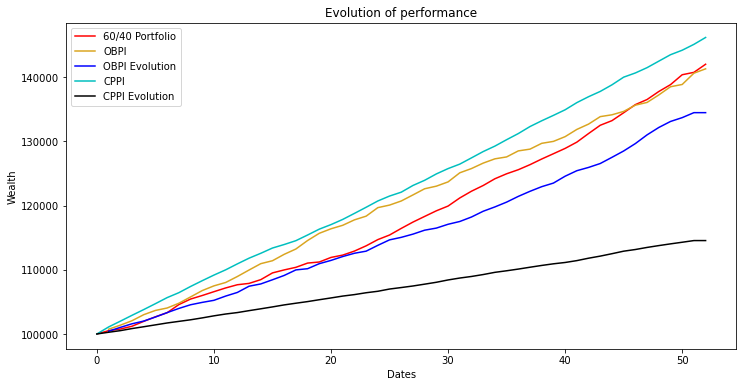

In [213]:
ax = show_hold.wealth.mean(axis=1).plot(figsize=(12,6), color = "r")
show_obpi.wealth.mean(axis=1).plot(ax=ax, figsize=(12,6), color = "goldenrod")
show_obpi_ev.wealth.mean(axis=1).plot(ax = ax, figsize=(12,6), color = "b")
show_cppi.wealth.mean(axis=1).plot(ax = ax, figsize=(12,6), color = "c")
show_cppi_ev.wealth.mean(axis=1).plot(ax = ax, figsize=(12,6), color = "k")
plt.xlabel("Dates")
plt.ylabel("Wealth")
plt.title("Evolution of performance")
plt.legend(["60/40 Portfolio","OBPI","OBPI Evolution","CPPI","CPPI Evolution"]);

# Theoretical stress test

In [157]:
# Creating a unique DataFrame for all strategies and S&P Crypto Index
data = pd.concat([hold_rets,sp_rets,obpi_rets,obpi_rets_ev,cppi_rets,cppi_rets_ev],axis=1)
returns=np.array(data)
n_obs=len(returns)
n_assets=returns.shape[1]
data.head()

,60/40 Portfolio Returns,S&P Prices,OBPI Returns,OBPI Returns,CPPI Returns,CPPI EV Returns
Date,,,,,,
2019-01-18,-0.007297,-0.017021,-0.001960,-0.001960,-0.011149,-0.011149
2019-01-25,-0.008195,-0.014476,-0.002206,-0.002206,-0.011771,-0.011771
2019-02-01,-0.027773,-0.040966,-0.008278,-0.008278,-0.037159,-0.037159
2019-02-08,0.033513,0.062931,0.010324,0.009324,0.033818,0.008461
2019-02-15,-0.005864,-0.011552,-0.001433,-0.001433,-0.007575,-0.006235


In [158]:
# Calculating a theoretical shock of a weekly -10% for the benchmark (S&P Crypto Index)
n_sim=1000
shock=-0.025
sim_shocks=np.zeros((n_sim,n_assets))
sim_shocks[:,1]=shock
for i in range(n_sim):
    # Resampling returns for the different strategies
    sim=resample(returns,replace=True)
    for j in range(n_assets):
        if j!=1:
            model = sm.OLS(sim[:,j],sm.add_constant(sim[:,1]))
            results = model.fit()
            betas=results.params 
            sim_shocks[i,j]=betas[0]+betas[1]*shock

## 60/40 Portfolio

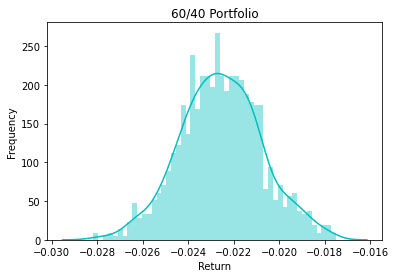

In [159]:
sns.distplot(sim_shocks[:,0],hist=True,kde=True,bins=50,color="c")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.title("60/40 Portfolio");

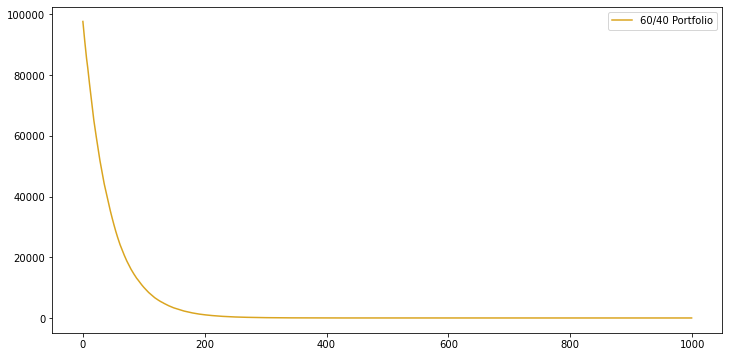

In [160]:
hold_stress = 100000*(1+pd.DataFrame(sim_shocks[:,0])).cumprod()
hold_stress.plot(figsize=(12,6), color = "goldenrod")
plt.legend(["60/40 Portfolio"]);

In [161]:
tv_hold = np.float64(hold_stress.iloc[-1])
round(tv_hold,2)

0.0

## OBPI

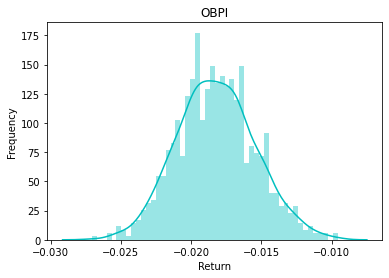

In [162]:
sns.distplot(sim_shocks[:,2],hist=True,kde=True,bins=50,color="c")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.title("OBPI");

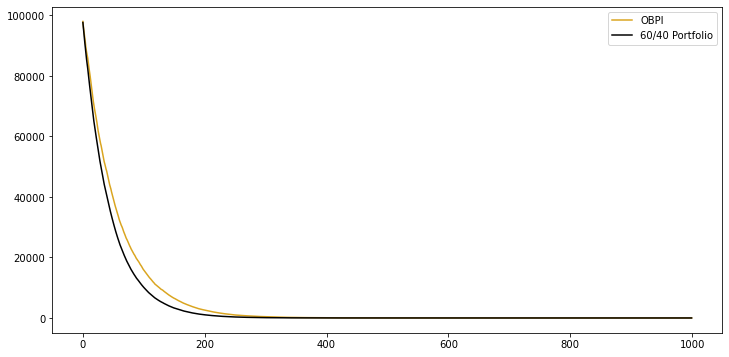

In [163]:
obpi_stress = 100000*(1+pd.DataFrame(sim_shocks[:,2])).cumprod()
ax = obpi_stress.plot(figsize=(12,6), color = "goldenrod")
hold_stress.plot(ax = ax, figsize=(12,6), color = "k")
plt.legend(["OBPI", "60/40 Portfolio"]);

In [164]:
tv_obpi = np.float64(obpi_stress.iloc[-1])
round(tv_obpi,2)

0.0

## Evolution of PI Strategies: OBPI subject to price jumps

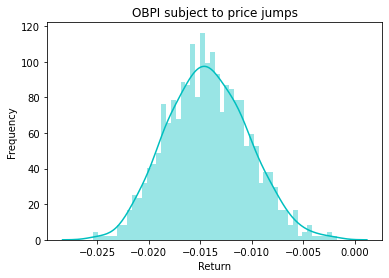

In [165]:
sns.distplot(sim_shocks[:,3],hist=True,kde=True,bins=50,color="c")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.title("OBPI subject to price jumps");

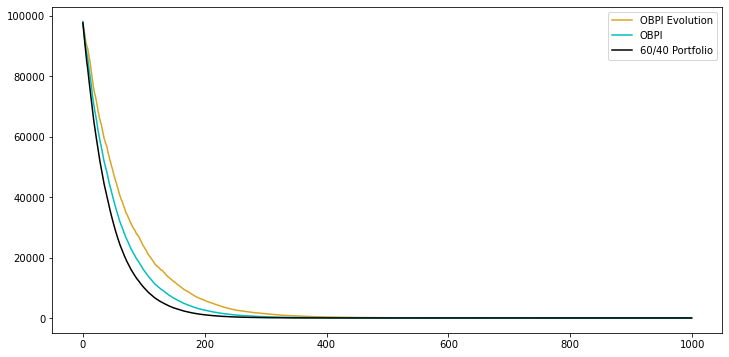

In [166]:
obpi_stress_ev = 100000*(1+pd.DataFrame(sim_shocks[:,3])).cumprod()
ax = obpi_stress_ev.plot(figsize=(12,6), color = "goldenrod")
obpi_stress.plot(ax = ax, figsize=(12,6), color = "c")
hold_stress.plot(ax = ax, figsize=(12,6), color = "k")
plt.legend(["OBPI Evolution","OBPI", "60/40 Portfolio"]);

In [167]:
tv_obpi_ev = np.float64(obpi_stress_ev.iloc[-1])
round(tv_obpi_ev,2)

0.06

## CPPI

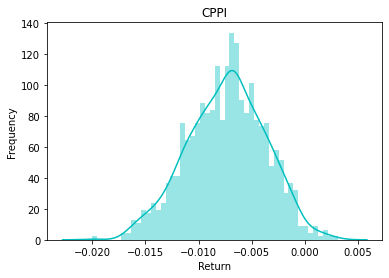

In [168]:
sns.distplot(sim_shocks[:,4],hist=True,kde=True,bins=50,color="c")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.title("CPPI");

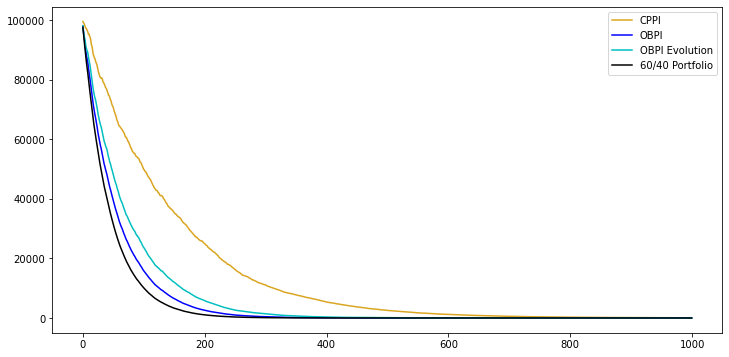

In [169]:
cppi_stress = 100000*(1+pd.DataFrame(sim_shocks[:,4])).cumprod()
ax = cppi_stress.plot(figsize=(12,6), color = "goldenrod")
obpi_stress.plot(ax = ax, figsize=(12,6), color = "b")
obpi_stress_ev.plot(ax = ax, figsize=(12,6), color = "c")
hold_stress.plot(ax = ax, figsize=(12,6), color = "k")
plt.legend(["CPPI","OBPI", "OBPI Evolution","60/40 Portfolio"]);

In [170]:
tv_cppi = np.float64(cppi_stress.iloc[-1])
round(tv_cppi,2)

60.74

## Evolution of PI Strategies: CPPI subject to price jumps

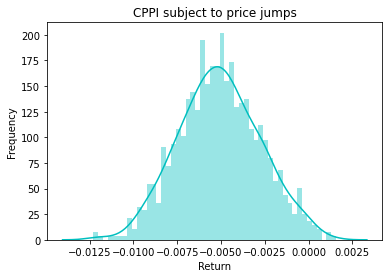

In [171]:
sns.distplot(sim_shocks[:,5],hist=True,kde=True,bins=50,color="c")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.title("CPPI subject to price jumps");

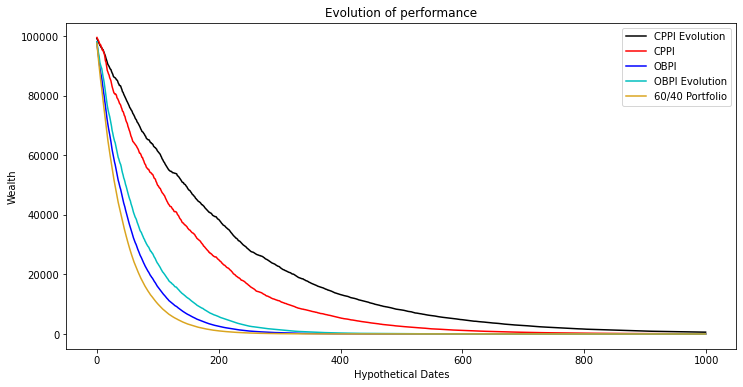

In [208]:
cppi_ev_stress = 100000*(1+pd.DataFrame(sim_shocks[:,5])).cumprod()
ax = cppi_ev_stress.plot(figsize=(12,6), color = "k")
cppi_stress.plot(ax=ax, figsize=(12,6), color = "r")
obpi_stress.plot(ax = ax, figsize=(12,6), color = "b")
obpi_stress_ev.plot(ax = ax, figsize=(12,6), color = "c")
hold_stress.plot(ax = ax, figsize=(12,6), color = "goldenrod")
plt.xlabel("Hypothetical Dates")
plt.ylabel("Wealth")
plt.title("Evolution of performance")
plt.legend(["CPPI Evolution","CPPI","OBPI","OBPI Evolution", "60/40 Portfolio"]);

Text(0.5, 1.0, 'Evolution of performance')

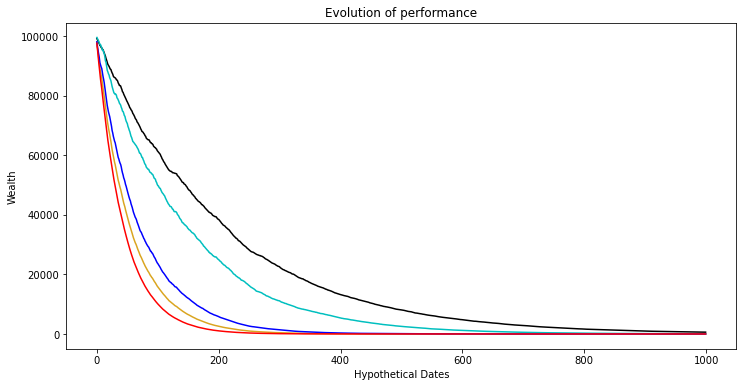

In [211]:
cppi_ev_stress = 100000*(1+pd.DataFrame(sim_shocks[:,5])).cumprod()
ax = cppi_ev_stress.plot(figsize=(12,6), color = "k", legend=None)
cppi_stress.plot(ax=ax, figsize=(12,6), color = "c", legend=None)
obpi_stress.plot(ax = ax, figsize=(12,6), color = "goldenrod", legend=None)
obpi_stress_ev.plot(ax = ax, figsize=(12,6), color = "b", legend=None)
hold_stress.plot(ax = ax, figsize=(12,6), color = "r", legend=None)
plt.xlabel("Hypothetical Dates")
plt.ylabel("Wealth")
plt.title("Evolution of performance")
#plt.legend(["CPPI Evolution","CPPI","OBPI","OBPI Evolution", "60/40 Portfolio"]);

In [173]:
tv_cppi_ev = np.float64(cppi_ev_stress.iloc[-1])
round(tv_cppi_ev,2)

610.21

# Summary statistics for stress testing

In [174]:
hold_shock = pd.DataFrame(sim_shocks[:,0])
summary_stats(hold_shock)

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
0,-0.6947,0.013,0.013,0.0372,3.0146,0.0255,0.0255,0.0263,-27.2592,-53.3705,-53.3705,-0.6948,-0.7192,-1.0


In [175]:
obpi_shock = pd.DataFrame(sim_shocks[:,2])
summary_stats(obpi_shock)

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
0,-0.6157,0.02,0.02,0.1191,2.9398,0.0226,0.0227,0.0237,-27.2532,-30.8206,-30.8206,-0.6159,-0.6431,-1.0


In [176]:
obpi_shock_ev = pd.DataFrame(sim_shocks[:,3])
summary_stats(obpi_shock_ev)

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
0,-0.5266,0.0282,0.0282,0.1467,2.8505,0.0206,0.0206,0.0218,-25.6079,-18.6679,-18.6679,-0.5269,-0.5572,-1.0


In [177]:
cppi_shock = pd.DataFrame(sim_shocks[:,4])
summary_stats(cppi_shock)

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
0,-0.3196,0.0264,0.0254,-0.1355,2.7848,0.0137,0.0135,0.0151,-23.3388,-12.1225,-12.6023,-0.3202,-0.3598,-0.9994


In [178]:
cppi_ev_shock = pd.DataFrame(sim_shocks[:,5])
summary_stats(cppi_ev_shock)

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
0,-0.2329,0.0168,0.0162,0.0354,2.8036,0.0089,0.0089,0.0098,-26.255,-13.9023,-14.3793,-0.2347,-0.2785,-0.9939
